# OC PROJET 6 - Classifier des images à l'aide d'algorithmes de Deep Learning
### INTRODUCTION

<div id="toc"></div>

Ce projet à pour but de classifier automatiquement des images de chiens en se basant 
sur le dataset de Stanford Dogs Dataset (http://vision.stanford.edu/aditya86/ImageNetDogs/).
Dans un premier temps on va créer un modèle from scratch, en appliquant des étapes de pre-processing
sur les images (redimensionnement, conversion en échelle de gris, normalization, whitening, etc.) ensuite
nous verrons l'approche en utilisant le transfer learning avec des modèles pré-entrainés.


### SOMMAIRE
- <a href="#C1">I. CNN From Scratch</a>
    - <a href="#C11">1. Gestions des dossiers</a>
    - <a href="#C12">2. Traitement des images</a>
    - <a href="#C13">3. Création du modèle</a>
    - <a href="#C14">4. Prédiction et sauvegarde du modèle</a>
<br></br>   
    
- <a href="#C2">II. Transfer Learning</a>
     - 1. <a href="#C21">MobileNetV2</a>
     - 2. <a href="#C22">InceptionV3</a>
     - 3. <a href="#C23">Xception</a>
     - 4. <a href="#C24">Sélection Finale</a>
     

<br></br>      


# <a name="C1">I. CNN From Scratch</a>

In [4]:
import os
import re
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager as fm, rcParams
import matplotlib.patheffects as path_effects
import seaborn as sns
import PIL
from PIL import Image
import pathlib
import shutil
import random
import io
from io import BytesIO
import requests
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras import applications
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import Xception
from keras.optimizers import Adam
from keras.layers import Input
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [5]:
# Ajouter une ombre à la police
shadow = path_effects.withSimplePatchShadow(offset = (1,
- 0.75), shadow_rgbFace='darkblue', alpha = 0.25)

# Utiliser la police dans les graphiques, changer la couleur 
# et augmenter la résolution d'affichage
plt.rcParams['font.family'] = 'Ebrima'
plt.rcParams['text.color'] = 'white'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
plt.style.use('dark_background')
# set le theme seaborn
sns.set_style('darkgrid', {'axes.facecolor': '0.2',
'text.color': 'white','figure.figsize': (20, 16)})
plt.rcParams['figure.facecolor'] = '0.2'

# suppression de l'affichage max des colonnes
pd.set_option('display.max_columns', None)

## 1. <a name="C11">Gestions des dossiers</a>
### 1.1 Renommer les sous dossiers

In [2]:
dossier_parent = "Images"

# Parcourir tous les sous-dossiers
for dossier in os.listdir(dossier_parent):
    chemin_dossier = os.path.join(dossier_parent, dossier)
    
    # Vérifier si le chemin est un dossier
    if os.path.isdir(chemin_dossier):
        # Extraire le nouveau nom du dossier en utilisant une expression régulière
        nouveau_nom = re.sub(r"^\w+-", "", dossier)
        
        # Renommer le dossier
        nouveau_chemin_dossier = os.path.join(dossier_parent, nouveau_nom)
        os.rename(chemin_dossier, nouveau_chemin_dossier)

### 1.2 Chargement des sous dossiers

In [2]:
# Chemin vers le dossier principal contenant les images par races
dataset_dir = "Images"

# Liste des noms des sous-dossiers (races)
subdirs = os.listdir(dataset_dir)

# Dictionnaire pour stocker les images prétraitées (y compris l'augmentation) par race
preprocessed_images_by_race = {}
preprocessed_images_by_race_clean = {}
preprocessed_images_by_race_resized = {}
preprocessed_images_by_race_gray = {}
preprocessed_images_by_race_equalized = {}
preprocessed_images_by_race_normalized = {}
preprocessed_images_by_race_whitened = {}
preprocessed_images_by_filename_augmented = {}

# listes pour stocker les différentes images afin de comprendre les différentes
# étapes du processus de traitement des images
images = []
clean_images_list = []
resized_images_list = []
gray_images_list = []
equalized_images_list = []
normalized_images_list = []
whitenened_images_list = []
augmented_images = []

## 2. <a name="C12">Traitement des images</a>

In [3]:
# Paramètres de data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [4]:
# Nombre d'images augmentées par image d'origine
num_augmented_images = 4

In [5]:
# Taille de redimensionnement des images
new_size = (256, 256)

In [6]:
# Parcourir les sous-dossiers et charger les images
for subdir in subdirs[:10]:
    subdir_path = os.path.join(dataset_dir, subdir)
    
    # Vérifier si le chemin est un dossier
    if os.path.isdir(subdir_path):
        
        # Parcourir les fichiers dans le sous-dossier
        for file_name in os.listdir(subdir_path):
            file_path = os.path.join(subdir_path, file_name)
            
            # Charger l'image en utilisant OpenCV
            image = cv2.imread(file_path)
            
            # Vérifier si l'image est valide
            if image is not None:
                # Redimensionner l'image
                clean_images_list.append(image)
                image_resized = cv2.resize(image, new_size)
                resized_images_list.append(image_resized)
                
                # Convertir en échelle de gris
                gray_image = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
                gray_images_list.append(gray_image)
                
                # Equalisation d'histogramme
                equalized_image = cv2.equalizeHist(gray_image)
                equalized_images_list.append(equalized_image)
                
                # Normalisation
                normalized_image = equalized_image / 255.0
                normalized_images_list.append(normalized_image)
                
                # Whitening
                mean = np.mean(normalized_image)
                std = np.std(normalized_image)
                whitened_image = (normalized_image - mean) / std
                
                # Ajuster la forme de l'image pour l'augmentation des données
                whitened_image = np.expand_dims(whitened_image, axis=2)
                whitenened_images_list.append(whitened_image)
                images.append(whitened_image)
                
                # Appliquer l'augmentation de données
                for _ in range(num_augmented_images):
                    augmented_image = datagen.random_transform(whitened_image)
                    augmented_images.append(augmented_image)
                preprocessed_images_by_filename_augmented[file_name] = [image] + augmented_images
                images.extend(augmented_images)
        
        # Stocker les images prétraitées (y compris l'augmentation) dans le dictionnaire par race
        preprocessed_images_by_race[subdir] = images
        preprocessed_images_by_race_clean[subdir] = clean_images_list
        preprocessed_images_by_race_resized[subdir] = resized_images_list
        preprocessed_images_by_race_gray[subdir] = gray_images_list
        preprocessed_images_by_race_equalized[subdir] = equalized_images_list
        preprocessed_images_by_race_normalized[subdir] = normalized_images_list
        preprocessed_images_by_race_whitened[subdir] = whitenened_images_list

### 2.1 Visualisation des étapes de traitement

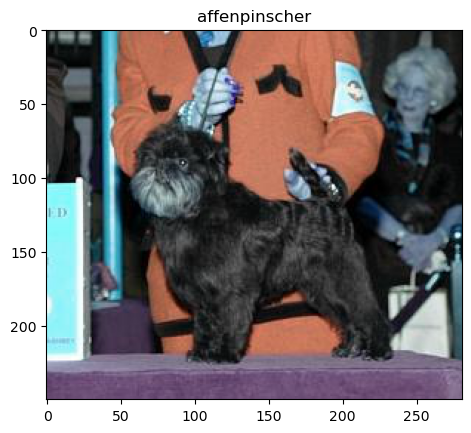

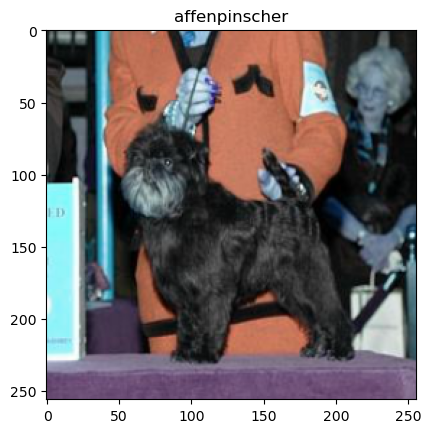

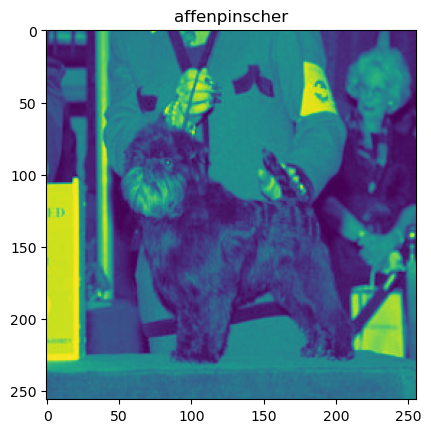

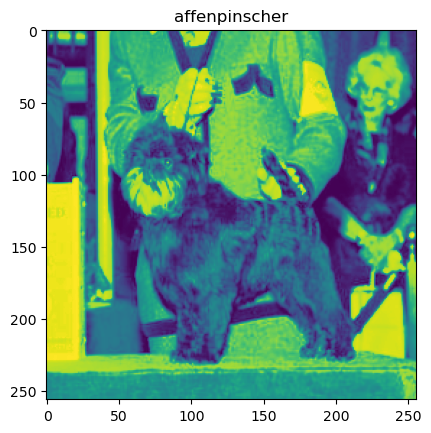

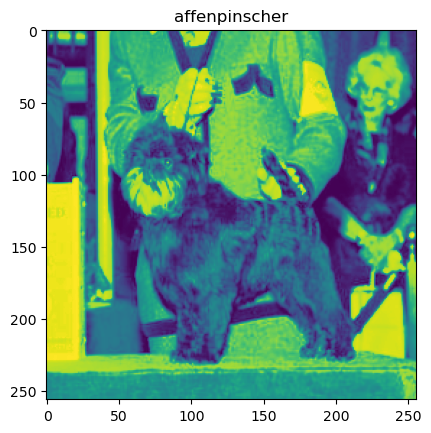

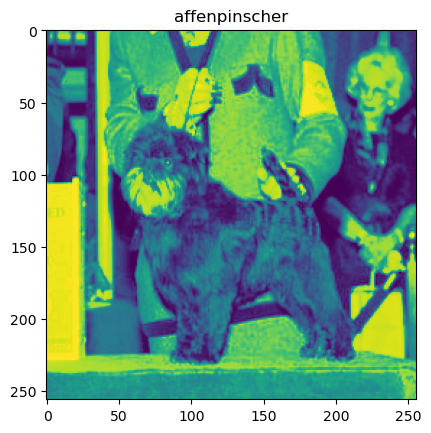

In [7]:
subdir = 'affenpinscher'

dictionaries = [preprocessed_images_by_race_clean, 
preprocessed_images_by_race_resized, preprocessed_images_by_race_gray, 
preprocessed_images_by_race_equalized, preprocessed_images_by_race_normalized, 
preprocessed_images_by_race_whitened]

for dictionary in dictionaries:
    if subdir in dictionary:
        img_list = dictionary[subdir]
        if len(img_list) > 0:
            img_test = img_list[0]
            plt.imshow(img_test)
            plt.title(subdir)
            plt.show()

### 2.2 Visualisation de la data augmentation

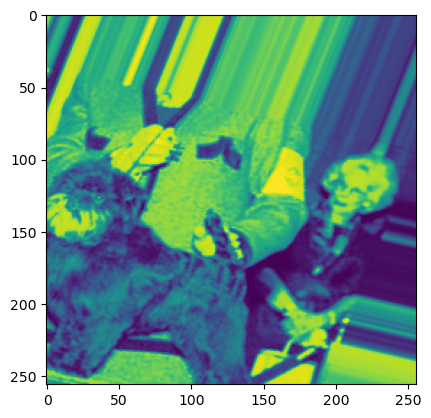

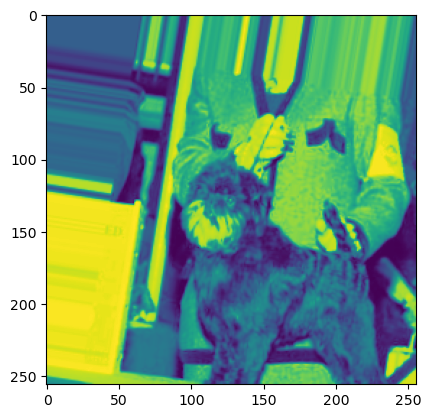

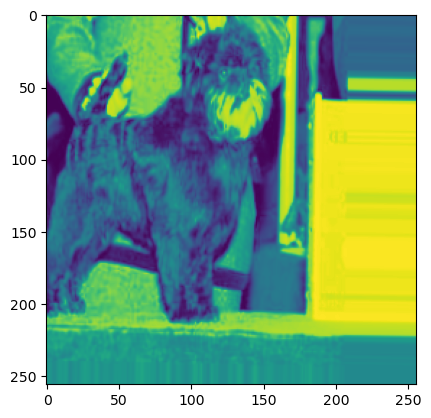

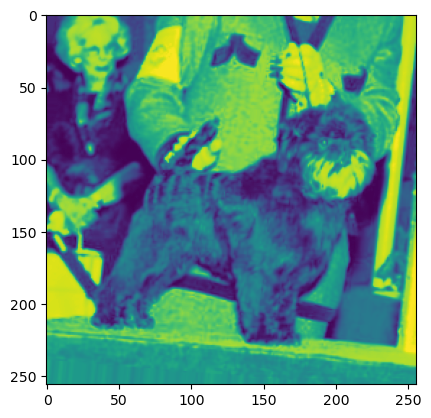

In [8]:
image_filenames = ['n02110627_10147.jpg']

for filename in image_filenames:
    for index in 1, 2, 3, 4:
        img_augmented = preprocessed_images_by_filename_augmented[filename][index]
        plt.imshow(img_augmented)
        plt.show()

## 3. <a name="C13">Création du modèle</a>
### 3.1 Création du training set

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  preprocessed_images_by_race,
  validation_split = 0.2,
  subset = "training",
  seed = 123,
  image_size = (256, 256),
  batch_size = 32)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.


### 3.2 Création du validation set

In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  preprocessed_images_by_race,
  validation_split = 0.2,
  subset = "validation",
  seed = 123,
  image_size = (256, 256),
  batch_size = 32)

Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


### 3.3 Récupération des étiquettes

In [11]:
class_names = train_ds.class_names
print(class_names)

['Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd', 'German_short-haired_pointer', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', 'Maltese_dog', 'Mexican_hairless', 'Newfoundland', 'Norfolk_terrier', 'Norwegian_elkhound', 'Norwich_terrier', 'Old_English_sheepdog', 'Pekinese', 'Pembroke', 'Po

### 3.4 Pipeline de traitement de données

In [14]:
# Création de deux pipelines de traitement de données (train_ds et val_ds) pour l'entraînement et la validation 
# d'un modèle d'apprentissage automatique. On utilise la mise en cache des données pour accélérer les 
# itérations d'entraînement, mélange les données d'entraînement pour introduire de l'aléatoire et précharge 
# les données pour éviter les goulots d'étranglement pendant l'entraînement. 
# Ces techniques sont couramment utilisées pour optimiser le flux de données lors de l'entraînement de modèles 
# d'apprentissage profond.

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
# Normalizarion
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

In [ ]:
# création du modèle
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

### 3.5 Entrainement du modèle

In [15]:
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = 10
)

Epoch 1/10
515/515 [==============================] - 279s 537ms/step - loss: 4.7375 - accuracy: 0.0171 - val_loss: 4.5864 - val_accuracy: 0.0245
Epoch 2/10
515/515 [==============================] - 301s 581ms/step - loss: 4.3676 - accuracy: 0.0475 - val_loss: 4.2682 - val_accuracy: 0.0573
Epoch 3/10
515/515 [==============================] - 308s 595ms/step - loss: 3.9972 - accuracy: 0.0909 - val_loss: 4.1615 - val_accuracy: 0.0724
Epoch 4/10
515/515 [==============================] - 322s 622ms/step - loss: 3.3817 - accuracy: 0.1992 - val_loss: 4.4053 - val_accuracy: 0.0722
Epoch 5/10
515/515 [==============================] - 308s 595ms/step - loss: 2.2388 - accuracy: 0.4299 - val_loss: 5.2736 - val_accuracy: 0.0705
Epoch 6/10
515/515 [==============================] - 298s 577ms/step - loss: 1.0146 - accuracy: 0.7263 - val_loss: 7.7179 - val_accuracy: 0.0598
Epoch 7/10
515/515 [==============================] - 333s 645ms/step - loss: 0.3712 - accuracy: 0.9032 - val_loss: 10.2810 

### 3.6 Evaluation du modèle

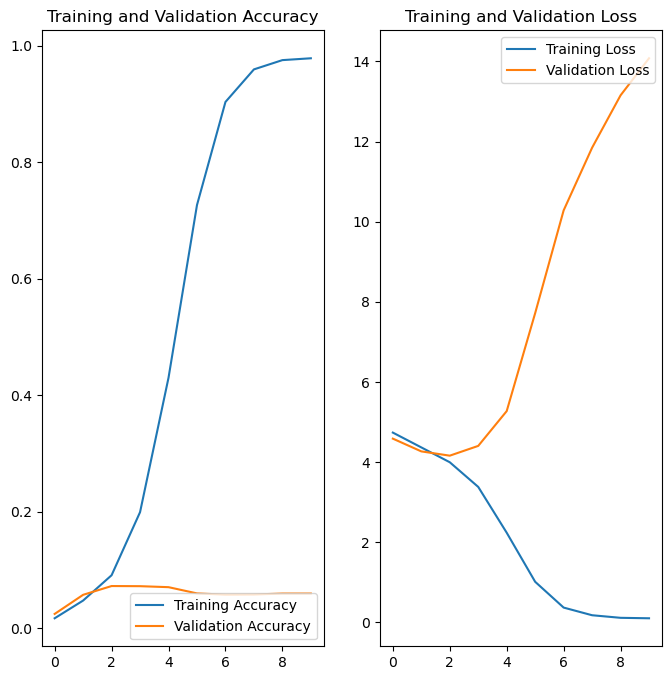

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 4. <a name="C14">Prédiction et sauvegarde du modèle</a>

### 4.1 Prédiction

In [27]:
bull_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/b/bf/Bulldog_inglese.jpg/220px-Bulldog_inglese.jpg"
bull_path = tf.keras.utils.get_file('bul', origin=bull_url)

img = tf.keras.utils.load_img(
    bull_path, target_size=(256, 256)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 3s 3s/step
This image most likely belongs to Blenheim_spaniel with a 27.33 percent confidence.


### 4.2 Sauvegarde du modèle

In [ ]:
tf.keras.models.save_model(
    model,
    filepath="model_cnn_5_v1.00",
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)

On voit que le modèle performe très mal mais on va le sauvegarder tout de même pour garder la piste qui a été explorée

# <a name="C2">II. Transfer Learning</a>
<a href="#toc">Revenir en haut</a>

Note : Afin d'éviter d'alourdir le notebook j'ai volontairement enlever tout les tests non concluant avec les différends modèles de transfer learning essayé. Ici une liste des résultats que je n'ai pas gardé : 

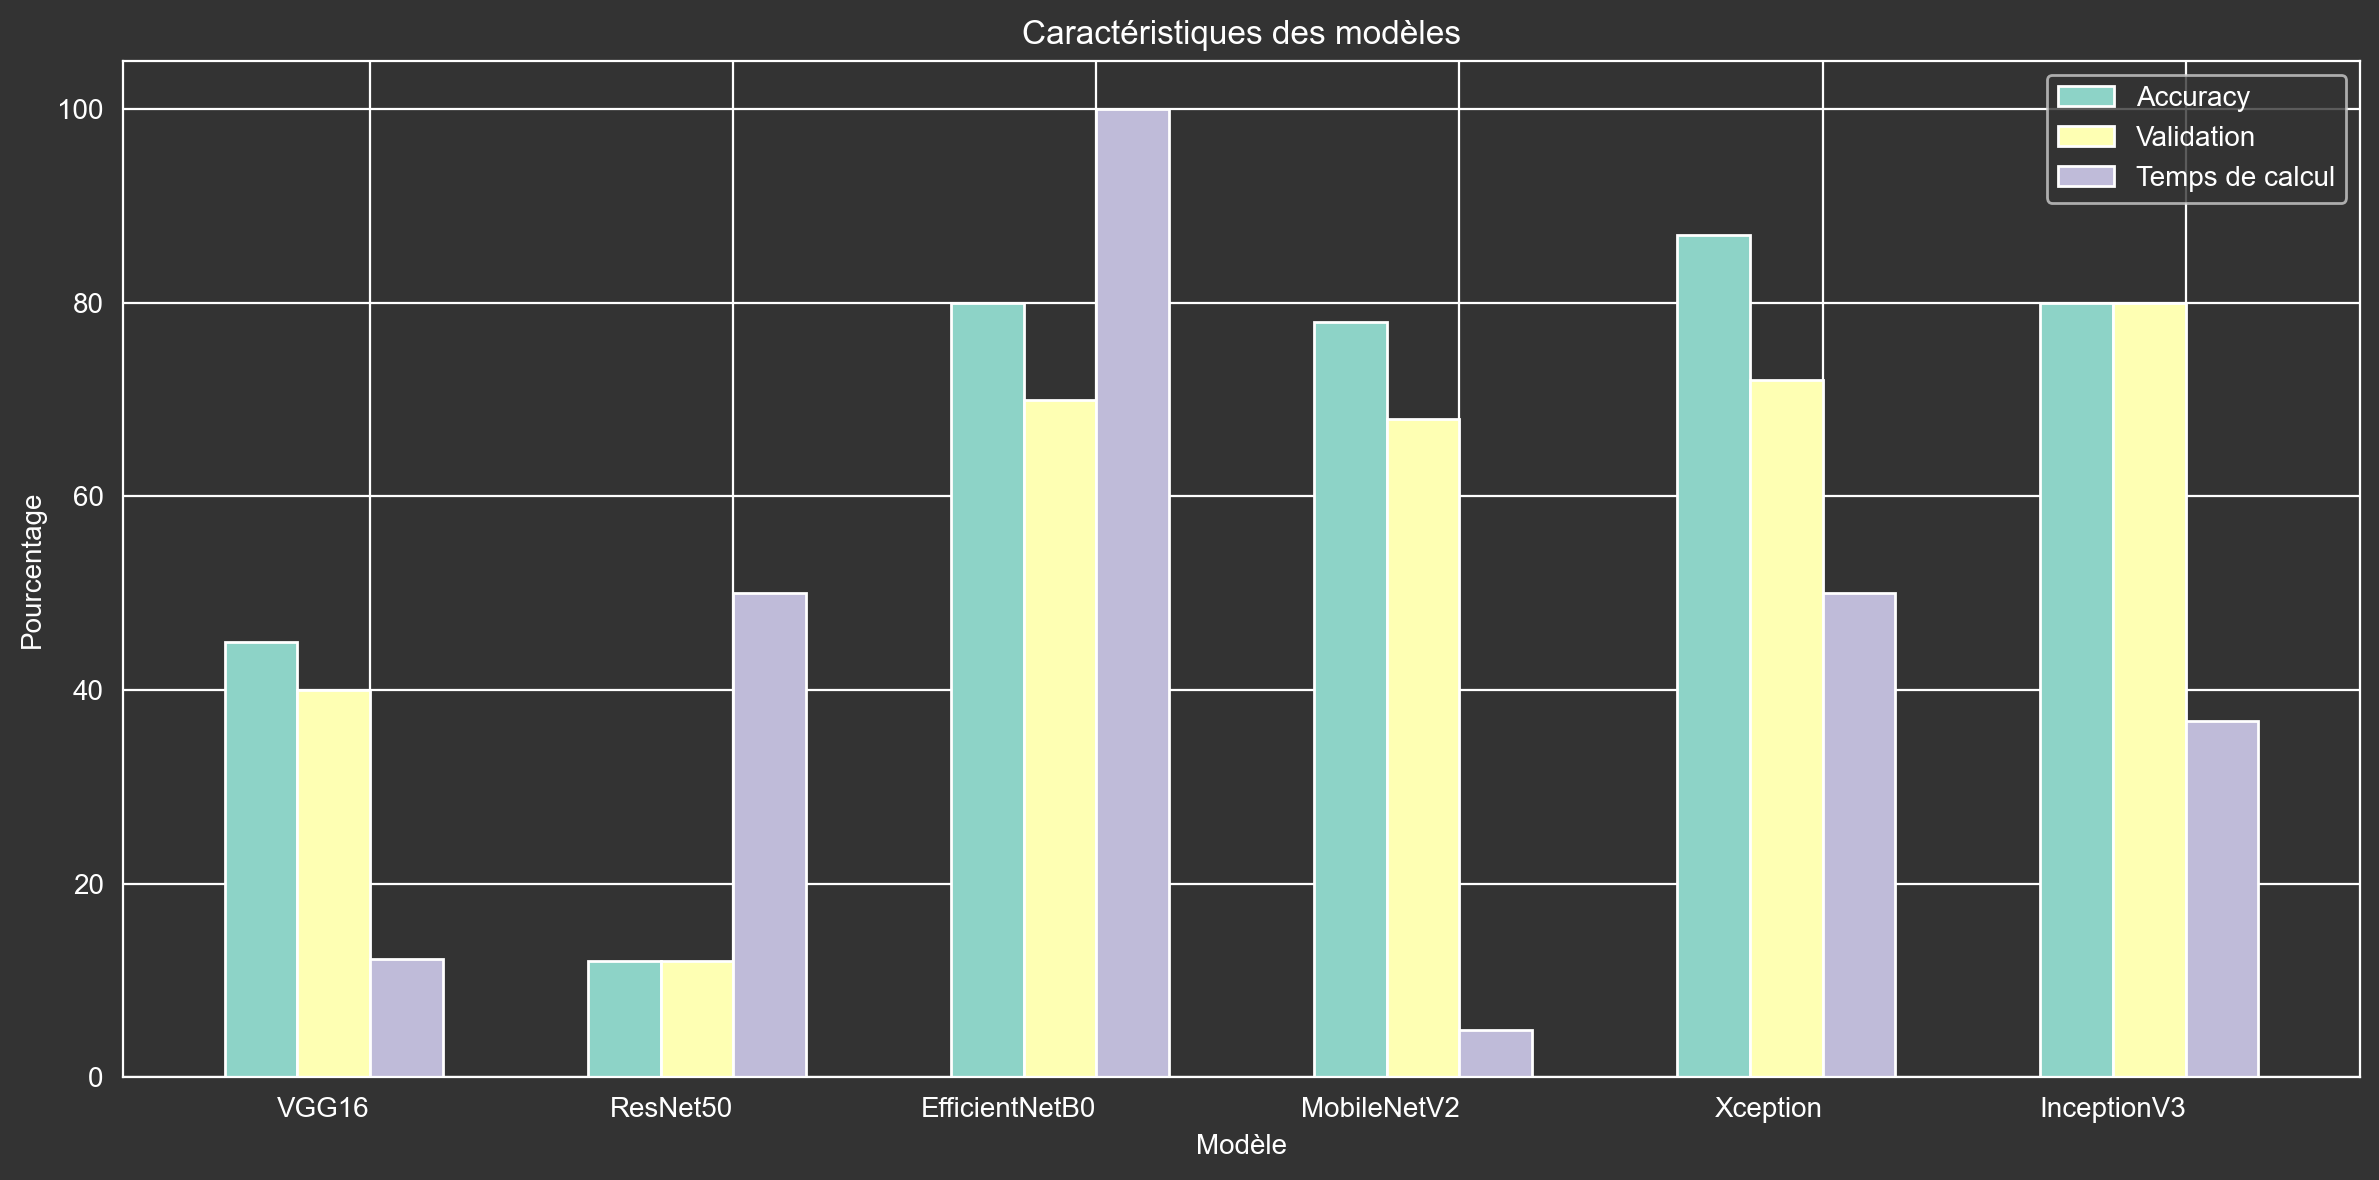

In [17]:
# Données
models = [
    "VGG16",
    "ResNet50",
    "EfficientNetB0",
    "MobileNetV2",
    "Xception",
    "InceptionV3"
]

accuracy = [45, 12, 80, 78, 87, 80]
validation = [40, 12, 70, 68, 72, 80]
computing_time = [0.245*50, 1*50, 2*50, 0.098*50, 1*50, 0.737*50]

# Création du graphique
plt.figure(figsize=(12, 6))
index = range(len(models))
bar_width = 0.2

plt.bar(index, accuracy, bar_width, label='Accuracy')
plt.bar([i + bar_width for i in index], validation, bar_width, label='Validation')
plt.bar([i + bar_width * 2 for i in index], computing_time, bar_width, label='Temps de calcul')

plt.xlabel('Modèle', color = 'white')
plt.ylabel('Pourcentage', color = 'white')
plt.title('Caractéristiques des modèles', color = 'white')
plt.xticks([i + bar_width * 1.5 for i in index], models, ha="right", color = 'white')
plt.yticks(color = 'white')
plt.legend()

plt.tight_layout()
plt.show()

### Paramètres pour chaques modèles : 

1. VGG16, 10EPOCH, 32 BATCH, (224, 224), Dense(256), relu<br>

2. ResNet50, 10EPOCH, 32 BATCH, (224,224), Dense(256), relu<br>

3. EfficientNet, 10 EPOCH, 32 BATCH, (224,224, 3), Dense(128), relu<br>

4. MobileNetV2, 10 EPOCH, 32 BATCH, (128,128), Dense(512), relu<br>

5. Xception, 20 EPOCH, 32 BATCH, (224,224), Dense(128), relu<br>

6. InceptionV3, 10 EPOCH, 32 BATCH, (299,299), Dense(1024), relu<br>


Nous allons maintenant nous concentrer sur les améliorations apportée sur MobileNetV2, InceptionV3 et Xception au vu de
leur benchmark prometteurs.

In [116]:
# affichage des modèles de transfer learning disponibles
available_models = [model_name for model_name in dir(applications) if not model_name.startswith('_')]
print(available_models)

['ConvNeXtBase', 'ConvNeXtLarge', 'ConvNeXtSmall', 'ConvNeXtTiny', 'ConvNeXtXLarge', 'DenseNet121', 'DenseNet169', 'DenseNet201', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7', 'EfficientNetV2B0', 'EfficientNetV2B1', 'EfficientNetV2B2', 'EfficientNetV2B3', 'EfficientNetV2L', 'EfficientNetV2M', 'EfficientNetV2S', 'InceptionResNetV2', 'InceptionV3', 'MobileNet', 'MobileNetV2', 'MobileNetV3Large', 'MobileNetV3Small', 'NASNetLarge', 'NASNetMobile', 'RegNetX002', 'RegNetX004', 'RegNetX006', 'RegNetX008', 'RegNetX016', 'RegNetX032', 'RegNetX040', 'RegNetX064', 'RegNetX080', 'RegNetX120', 'RegNetX160', 'RegNetX320', 'RegNetY002', 'RegNetY004', 'RegNetY006', 'RegNetY008', 'RegNetY016', 'RegNetY032', 'RegNetY040', 'RegNetY064', 'RegNetY080', 'RegNetY120', 'RegNetY160', 'RegNetY320', 'ResNet101', 'ResNet101V2', 'ResNet152', 'ResNet152V2', 'ResNet50', 'ResNet50V2', 'ResNetRS101', 'ResNetRS152', 'ResNe

## 1. <a name="C21">MobileNetV2</a>
<a href="#toc">Revenir en haut</a>

In [103]:
# Chemin vers le dossier principal contenant les images de chiens
data_dir = 'Images'

# Taille des images que le modèle attend en entrée
img_size = (224, 224)
num_classes = 120
epochs = 20

In [104]:
# Pré-traitement et data augmentation des images
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest'
)

In [105]:
# Charger les images depuis le répertoire et appliquer la data augmentation
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=64,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=64,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [106]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

In [107]:
# Ajouter une couche GlobalAveragePooling2D et une couche Dense pour la classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='tanh')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [108]:
# Combiner le modèle pré-entraîné avec nos nouvelles couches
model = Model(inputs=base_model.input, outputs=predictions)

In [109]:
# Geler les couches du modèle pré-entraîné pour empêcher leur mise à jour lors de l'entraînement
for layer in base_model.layers:
    layer.trainable = False

In [110]:
# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [111]:
# Afficher un résumé du modèle
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [112]:
# Entraîner le modèle
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Epoch 1/20
258/258 [==============================] - 232s 895ms/step - loss: 1.6066 - accuracy: 0.5675 - val_loss: 1.2988 - val_accuracy: 0.6351
Epoch 2/20
258/258 [==============================] - 239s 924ms/step - loss: 1.0871 - accuracy: 0.6796 - val_loss: 1.3027 - val_accuracy: 0.6346
Epoch 3/20
258/258 [==============================] - 253s 979ms/step - loss: 0.9656 - accuracy: 0.7060 - val_loss: 1.2471 - val_accuracy: 0.6493
Epoch 4/20
258/258 [==============================] - 284s 1s/step - loss: 0.8941 - accuracy: 0.7244 - val_loss: 1.2350 - val_accuracy: 0.6584
Epoch 5/20
258/258 [==============================] - 281s 1s/step - loss: 0.8536 - accuracy: 0.7410 - val_loss: 1.2796 - val_accuracy: 0.6567
Epoch 6/20
258/258 [==============================] - 247s 956ms/step - loss: 0.8141 - accuracy: 0.7494 - val_loss: 1.3127 - val_accuracy: 0.6510
Epoch 7/20
258/258 [==============================] - 265s 1s/step - loss: 0.7652 - accuracy: 0.7637 - val_loss: 1.2657 - val_accu

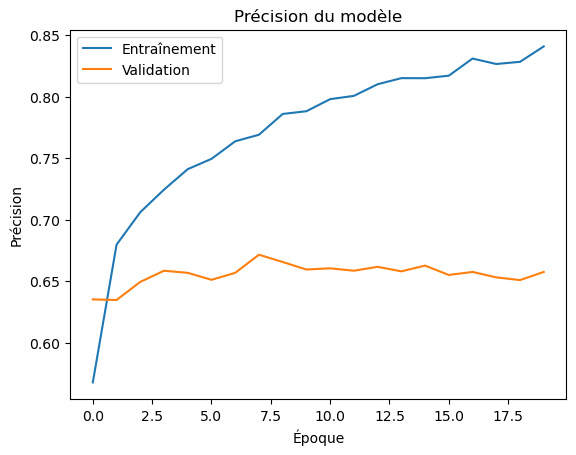

In [113]:
# Tracer les courbes d'apprentissage
# Précision d'entraînement et de validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du modèle')
plt.ylabel('Précision')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper left')
plt.show()

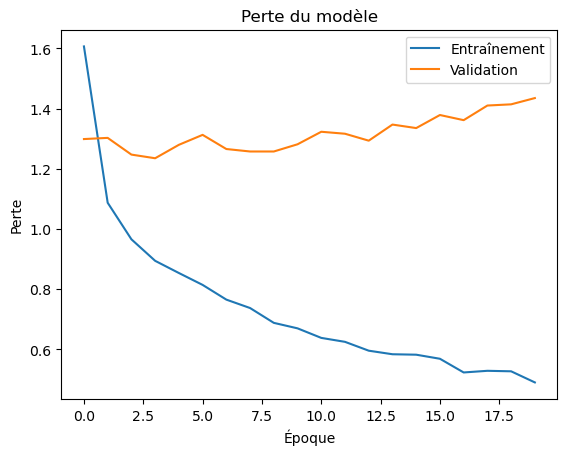

In [114]:
# Perte d'entraînement et de validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perte du modèle')
plt.ylabel('Perte')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper right')
plt.show()

In [115]:
# Classification report pour évaluer les performances du modèle sur le jeu de validation
# Prédictions sur le jeu de validation
Y_val_true = val_generator.classes
Y_val_pred = model.predict(val_generator)

64/64 [==============================] - 45s 693ms/step


In [116]:
# Récupérer les indices des classes prédites avec les probabilités les plus élevées
Y_val_pred_classes = np.argmax(Y_val_pred, axis=1)

In [117]:
# Afficher le classification report
class_labels = list(val_generator.class_indices.keys())
print(classification_report(Y_val_true, Y_val_pred_classes, target_names=class_labels))

                                precision    recall  f1-score   support

                  Afghan_hound       0.65      0.89      0.75        47
           African_hunting_dog       0.89      0.94      0.91        33
                      Airedale       0.73      0.75      0.74        40
American_Staffordshire_terrier       0.25      0.06      0.10        32
                   Appenzeller       0.83      0.17      0.28        30
            Australian_terrier       0.69      0.69      0.69        39
            Bedlington_terrier       1.00      0.72      0.84        36
          Bernese_mountain_dog       0.77      0.70      0.73        43
              Blenheim_spaniel       0.73      0.73      0.73        37
                 Border_collie       0.55      0.90      0.68        30
                Border_terrier       0.88      0.68      0.77        34
                   Boston_bull       0.64      0.83      0.72        36
          Bouvier_des_Flandres       0.61      0.63      0.62  

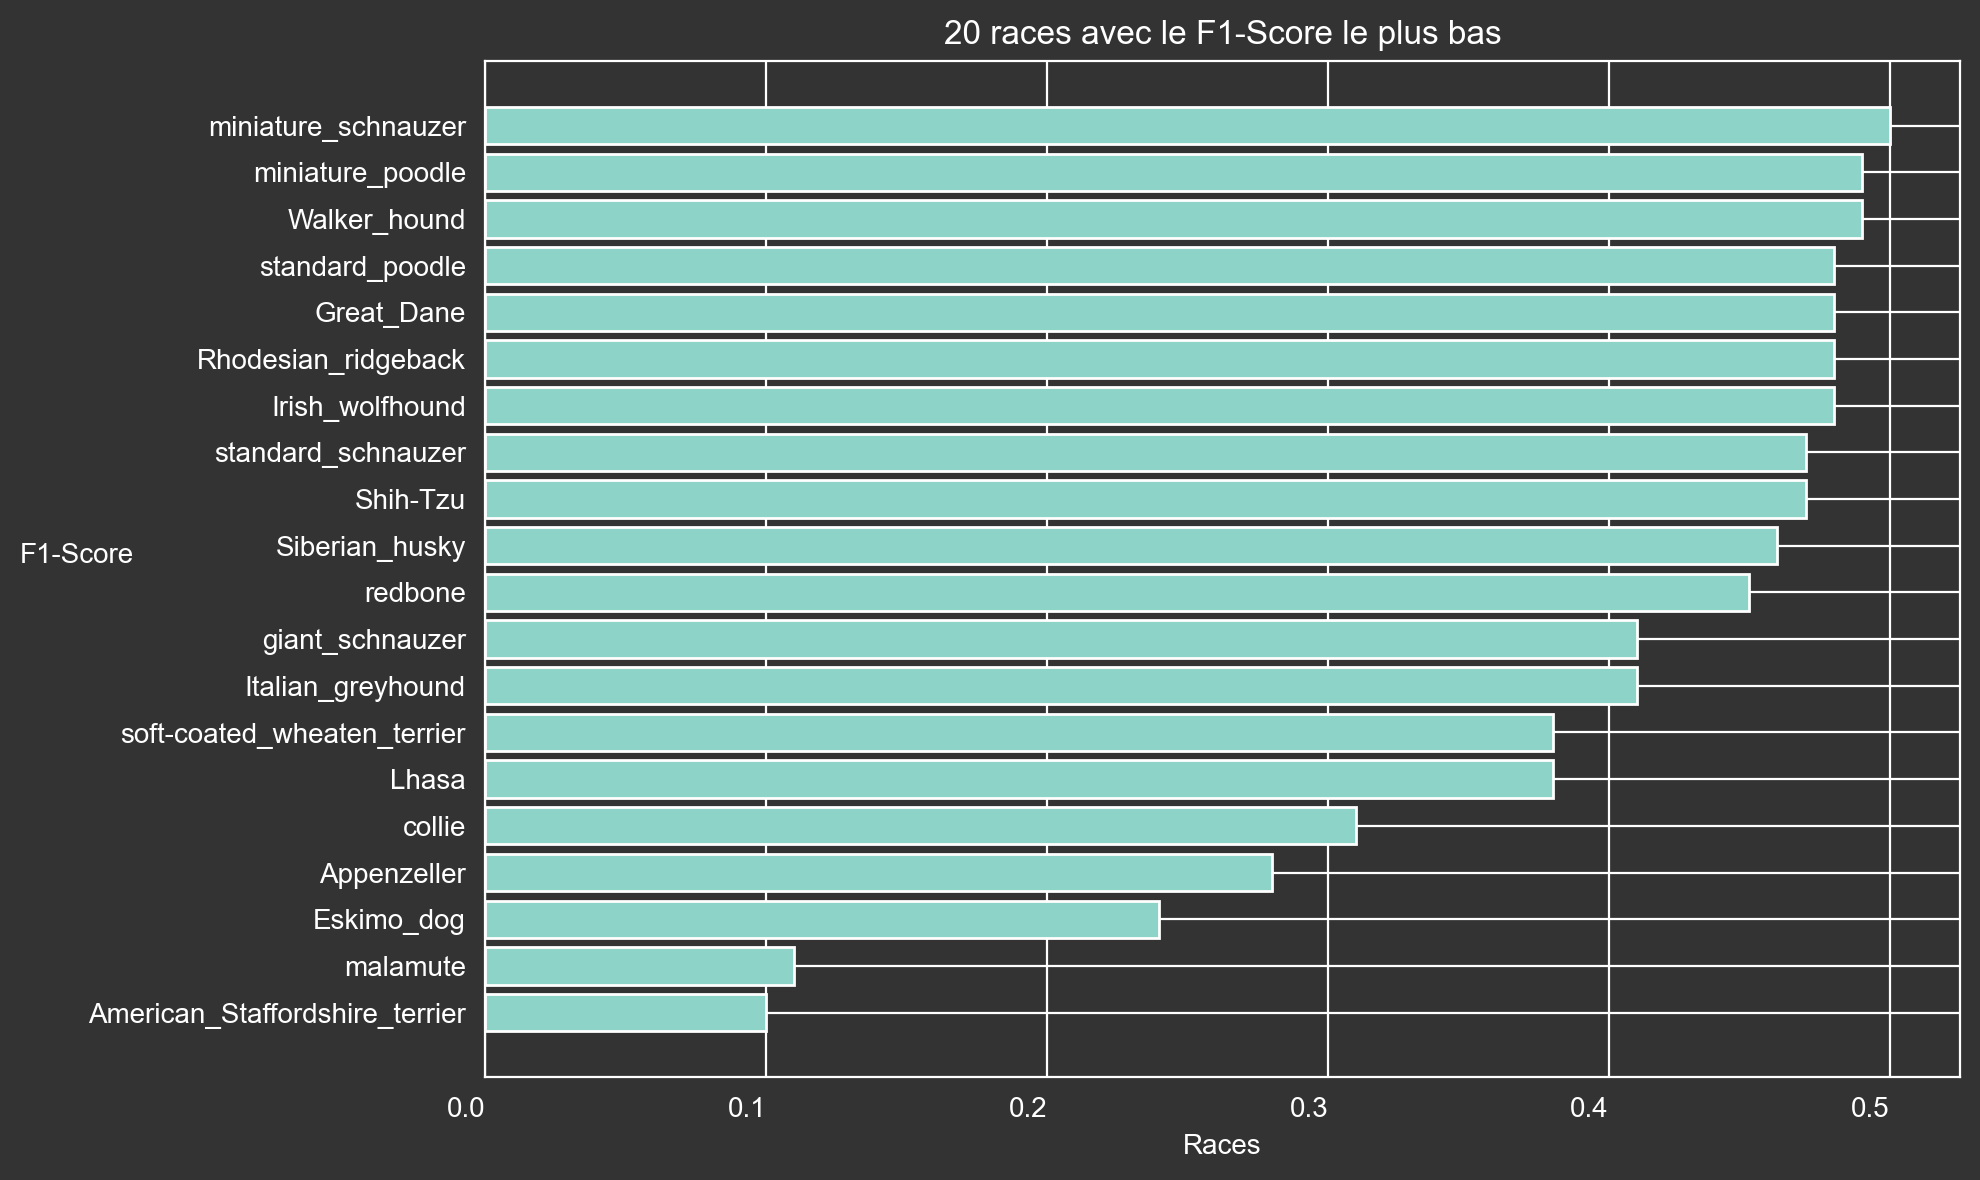

In [66]:
# Charger les données à partir du fichier CSV
df = pd.read_csv('mobilenetreport.csv')

# Trier les échantillons par ordre croissant d'accuracy
df_sorted = df.sort_values(by='f1-score', ascending=True)

# Sélectionner les 10 échantillons avec l'accuracy la plus basse
lowest_accuracy_samples = df_sorted.head(20)

# Créer un graphique en barre pour illustrer les échantillons
plt.figure(figsize=(10, 6))
plt.barh(lowest_accuracy_samples['breed'], lowest_accuracy_samples['f1-score'])
plt.xlabel('Races', color = 'white')
plt.ylabel('F1-Score', color = 'white', rotation = 360)
plt.title('20 races avec le F1-Score le plus bas')
plt.xticks(ha='right', color = 'white')
plt.yticks(color = 'white')
plt.tight_layout()

# Afficher le graphique
plt.show()

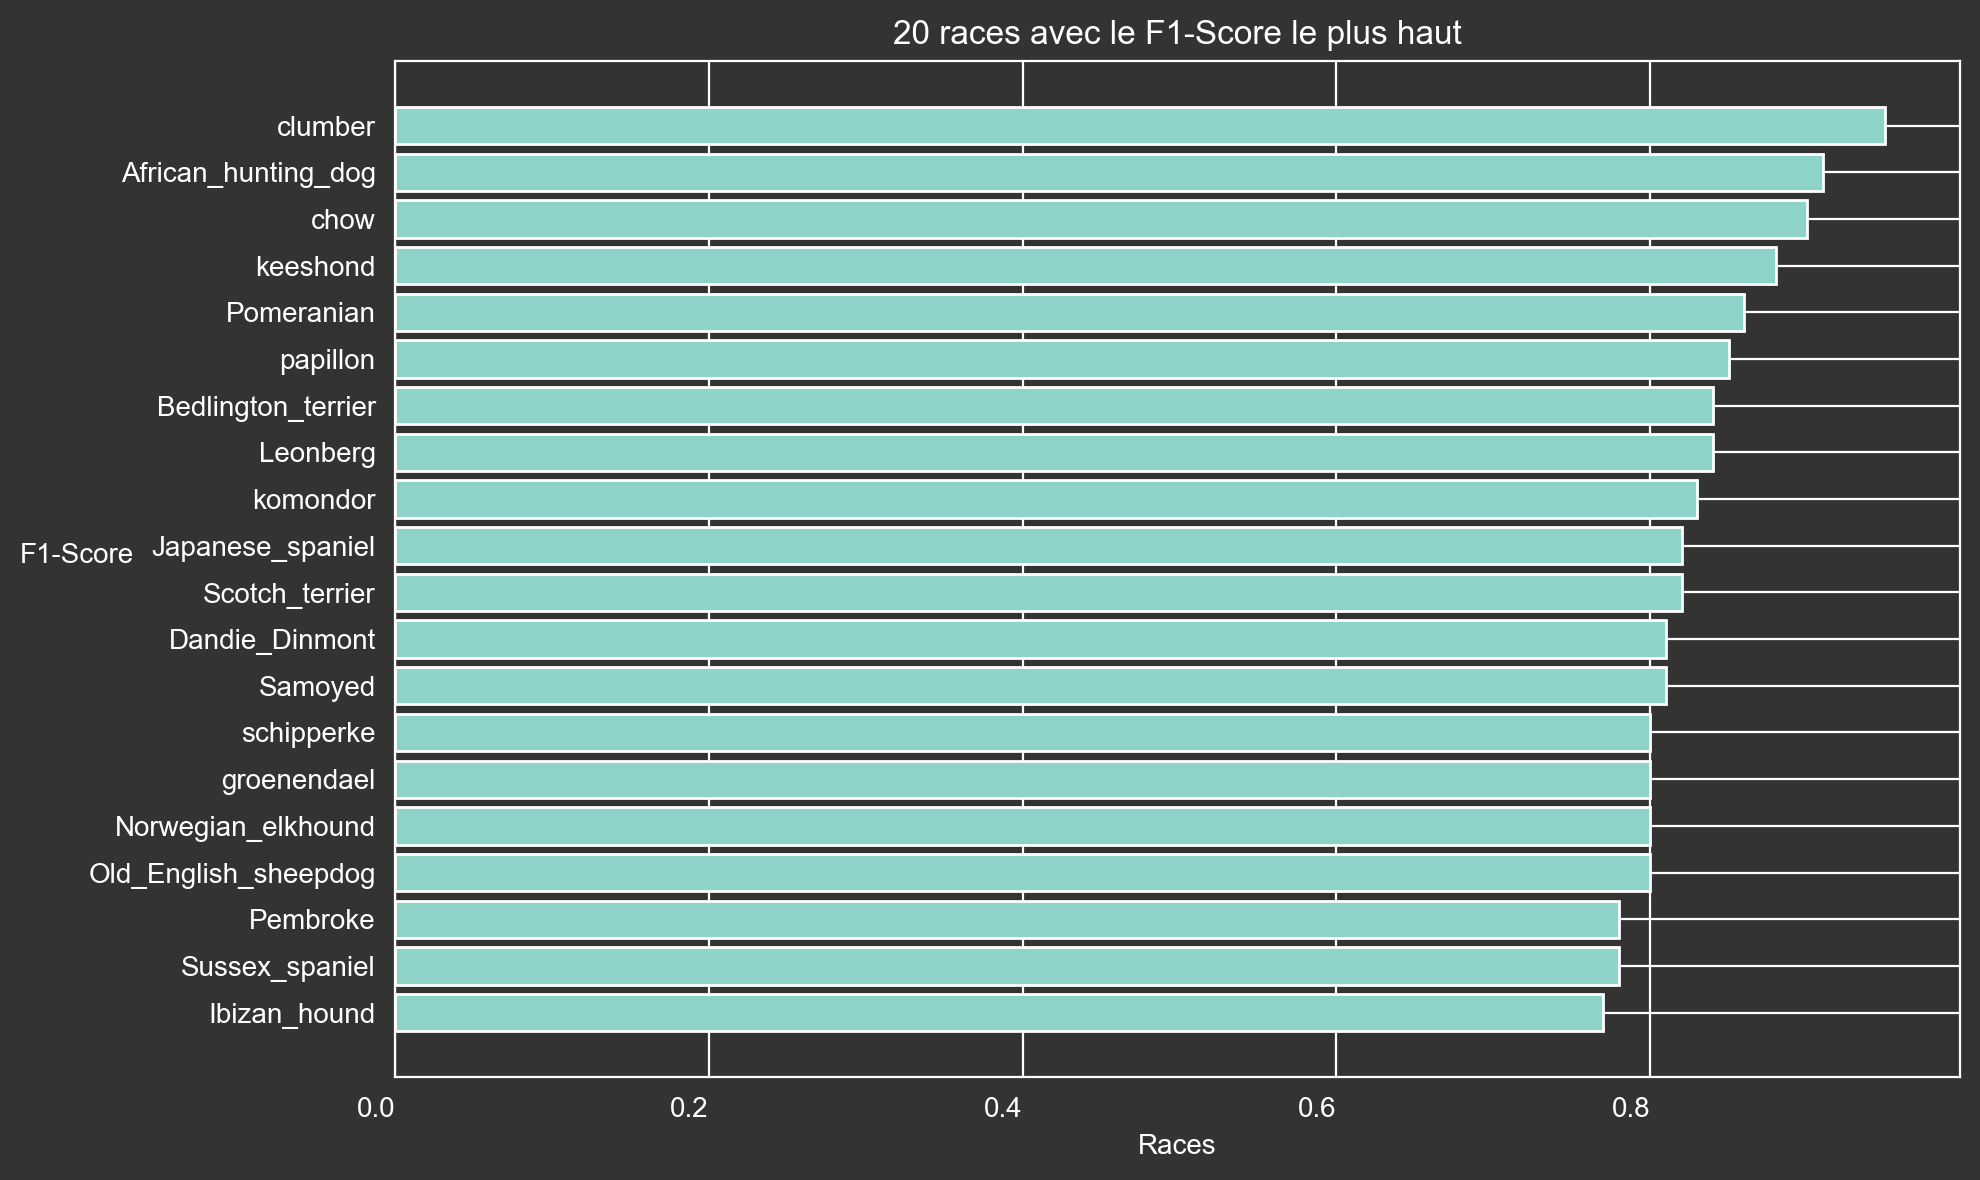

In [65]:
# Charger les données à partir du fichier CSV
df = pd.read_csv('mobilenetreport.csv')

# Trier les échantillons par ordre croissant d'accuracy
df_sorted = df.sort_values(by='f1-score', ascending=True)

# Sélectionner les 10 échantillons avec l'accuracy la plus basse
lowest_accuracy_samples = df_sorted.tail(20)

# Créer un graphique en barre pour illustrer les échantillons
plt.figure(figsize=(10, 6))
plt.barh(lowest_accuracy_samples['breed'], lowest_accuracy_samples['f1-score'])
plt.xlabel('Races', color = 'white')
plt.ylabel('F1-Score', color = 'white', rotation = 360)
plt.title('20 races avec le F1-Score le plus haut')
plt.xticks(ha='right', color = 'white')
plt.yticks(color = 'white')
plt.tight_layout()

# Afficher le graphique
plt.show()

In [118]:
tf.keras.models.save_model(
    model,
    filepath="model_transfer_mobilenet_v1.5",
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)

INFO:tensorflow:Assets written to: model_transfer_mobilenet_v1.5\assets


INFO:tensorflow:Assets written to: model_transfer_mobilenet_v1.5\assets


In [122]:
# Fonction pour télécharger l'image depuis l'URL et la prétraiter
def preprocess_image_from_url(image_url):
    response = requests.get(image_url)
    img = Image.open(io.BytesIO(response.content))
    img = img.resize((224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

In [123]:
# Charger la liste des noms de races de chiens
breed_list = sorted(os.listdir(data_dir))

In [124]:
# URL de l'image à prédire
image_url = "https://www.purina.fr/sites/default/files/2021-02/BREED%20Hero_0034_chihuahua_smooth.jpg"
# Prétraiter l'image et effectuer la prédiction
processed_image = preprocess_image_from_url(image_url)
prediction = model.predict(processed_image)
predicted_class = np.argmax(prediction)

# Calcul du pourcentage de confiance
confidence = np.max(prediction) * 100

# Afficher le résultat de la prédiction
print("Prédiction:", breed_list[predicted_class], " Confidence :", confidence)

1/1 [==============================] - 0s 347ms/step
Prédiction: Chihuahua  Confidence : 71.8813419342041


## 2. <a name="C22">InceptionV3</a>
<a href="#toc">Revenir en haut</a>

### 2.1 Préparation du modèle

In [6]:
# Chemin vers le dossier principal contenant les images de chiens
data_dir = 'Images'

In [7]:
# Taille des images que le modèle attend en entrée
img_size = (299, 299)
num_classes = 120
epochs = 20

In [8]:
# Pré-traitement et data augmentation des images
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest'
)

In [9]:
# Charger les images depuis le répertoire et appliquer la data augmentation
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=64,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

Found 16508 images belonging to 120 classes.


In [10]:
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=64,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

Found 4072 images belonging to 120 classes.


In [11]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

In [12]:
# Ajouter une couche GlobalAveragePooling2D et une couche Dense pour la classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='tanh')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [13]:
# Combiner le modèle pré-entraîné avec nos nouvelles couches
model = Model(inputs=base_model.input, outputs=predictions)

In [14]:
# Geler les couches du modèle pré-entraîné pour empêcher leur mise à jour lors de l'entraînement
for layer in base_model.layers:
    layer.trainable = False

In [15]:
# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Afficher un résumé du modèle
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

 batch_normalization_5 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 35, 35, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 35, 35, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 35, 35, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 35, 35, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 35, 35, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 17, 17, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 17, 17, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 17, 17, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 17, 17, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 17, 17, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 17, 17, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 17, 17, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 17, 17, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 8, 8, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 8, 8, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 8, 8, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

### 2.2 Entrainement du modèle

In [18]:
# Entraîner le modèle
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Epoch 1/20
258/258 [==============================] - 524s 2s/step - loss: 0.7317 - accuracy: 0.7897 - val_loss: 0.6849 - val_accuracy: 0.8016
Epoch 2/20
258/258 [==============================] - 534s 2s/step - loss: 0.6023 - accuracy: 0.8205 - val_loss: 0.6778 - val_accuracy: 0.8065
Epoch 3/20
258/258 [==============================] - 528s 2s/step - loss: 0.5464 - accuracy: 0.8334 - val_loss: 0.6220 - val_accuracy: 0.8210
Epoch 4/20
258/258 [==============================] - 529s 2s/step - loss: 0.5177 - accuracy: 0.8425 - val_loss: 0.7318 - val_accuracy: 0.7905
Epoch 5/20
258/258 [==============================] - 531s 2s/step - loss: 0.4838 - accuracy: 0.8500 - val_loss: 0.6914 - val_accuracy: 0.8094
Epoch 6/20
258/258 [==============================] - 532s 2s/step - loss: 0.4689 - accuracy: 0.8554 - val_loss: 0.6684 - val_accuracy: 0.8072
Epoch 7/20
258/258 [==============================] - 531s 2s/step - loss: 0.4657 - accuracy: 0.8546 - val_loss: 0.7108 - val_accuracy: 0.8033

### 2.3 Evaluation du modèle

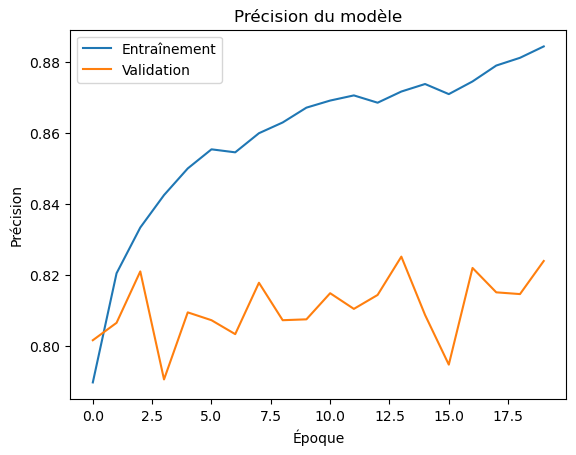

In [19]:
# Tracer les courbes d'apprentissage
# Précision d'entraînement et de validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du modèle')
plt.ylabel('Précision')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper left')
plt.show()

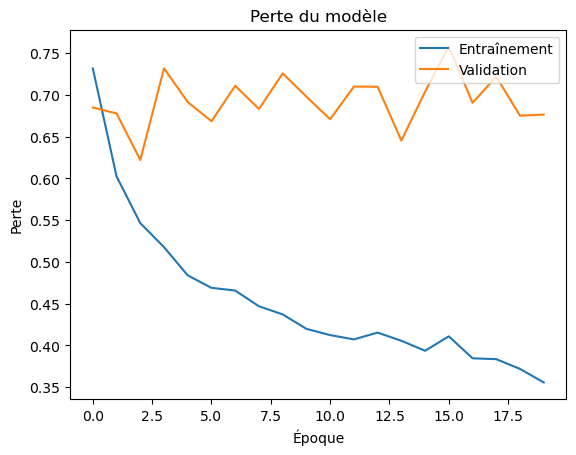

In [20]:
# Perte d'entraînement et de validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perte du modèle')
plt.ylabel('Perte')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper right')
plt.show()

In [21]:
# Classification report pour évaluer les performances du modèle sur le jeu de validation
# Prédictions sur le jeu de validation
Y_val_true = val_generator.classes
Y_val_pred = model.predict(val_generator)

64/64 [==============================] - 99s 2s/step


In [22]:
# Récupérer les indices des classes prédites avec les probabilités les plus élevées
Y_val_pred_classes = np.argmax(Y_val_pred, axis=1)

In [23]:
# Afficher le classification report
class_labels = list(val_generator.class_indices.keys())
print(classification_report(Y_val_true, Y_val_pred_classes, target_names=class_labels))

                                precision    recall  f1-score   support

                  Afghan_hound       0.85      0.98      0.91        47
           African_hunting_dog       0.97      0.97      0.97        33
                      Airedale       0.84      0.93      0.88        40
American_Staffordshire_terrier       0.52      0.81      0.63        32
                   Appenzeller       0.56      0.67      0.61        30
            Australian_terrier       0.86      0.82      0.84        39
            Bedlington_terrier       0.97      0.97      0.97        36
          Bernese_mountain_dog       0.80      0.93      0.86        43
              Blenheim_spaniel       0.97      0.86      0.91        37
                 Border_collie       0.64      1.00      0.78        30
                Border_terrier       0.81      1.00      0.89        34
                   Boston_bull       0.94      0.86      0.90        36
          Bouvier_des_Flandres       0.90      0.90      0.90  

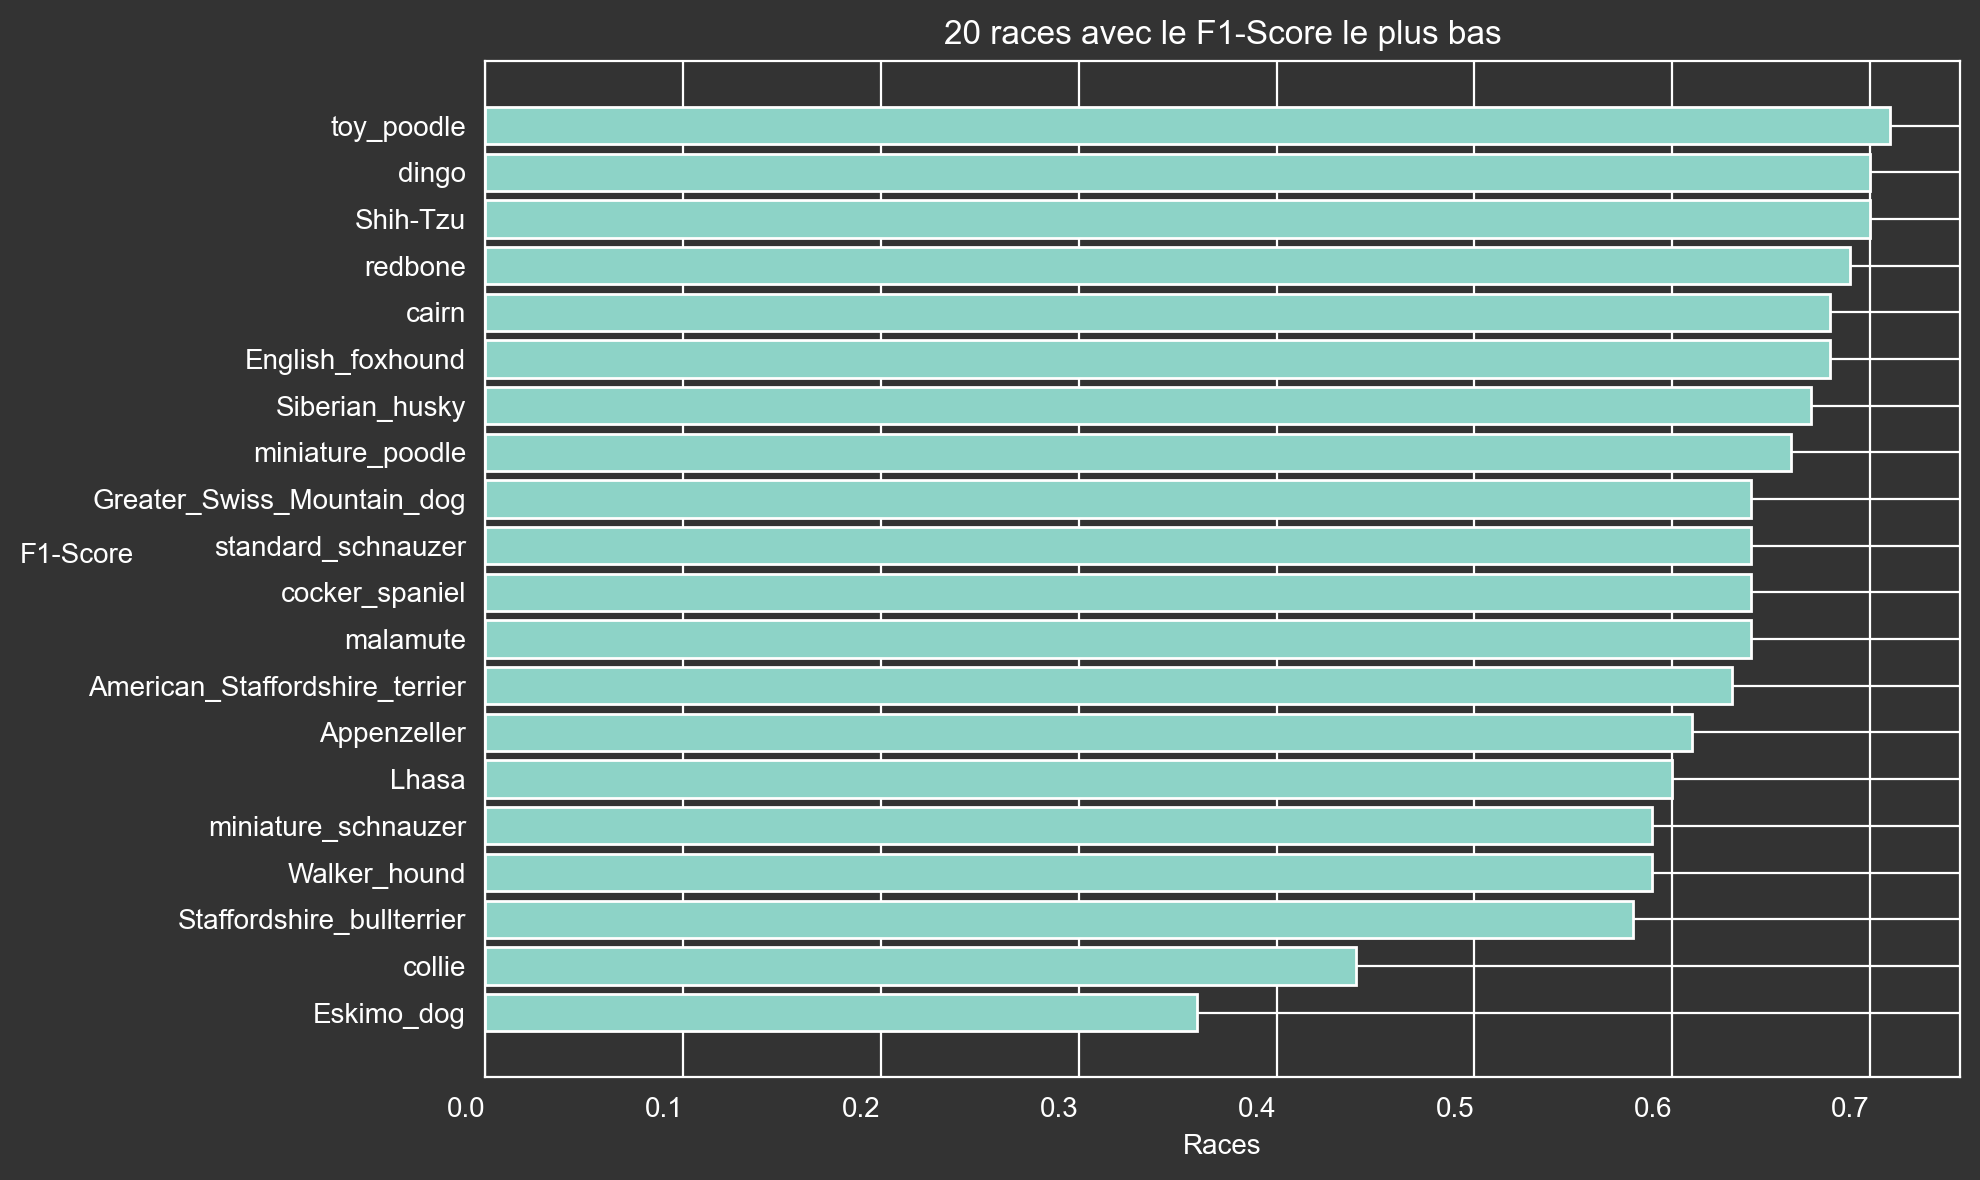

In [64]:
# Charger les données à partir du fichier CSV
df = pd.read_csv('inceptionreport.csv')

# Trier les échantillons par ordre croissant d'accuracy
df_sorted = df.sort_values(by='f1-score', ascending=True)

# Sélectionner les 10 échantillons avec l'accuracy la plus basse
lowest_accuracy_samples = df_sorted.head(20)

# Créer un graphique en barre pour illustrer les échantillons
plt.figure(figsize=(10, 6))
plt.barh(lowest_accuracy_samples['breed'], lowest_accuracy_samples['f1-score'])
plt.xlabel('Races', color = 'white')
plt.ylabel('F1-Score', color = 'white', rotation = 360)
plt.title('20 races avec le F1-Score le plus bas')
plt.xticks(ha='right', color = 'white')
plt.yticks(color = 'white')
plt.tight_layout()

# Afficher le graphique
plt.show()

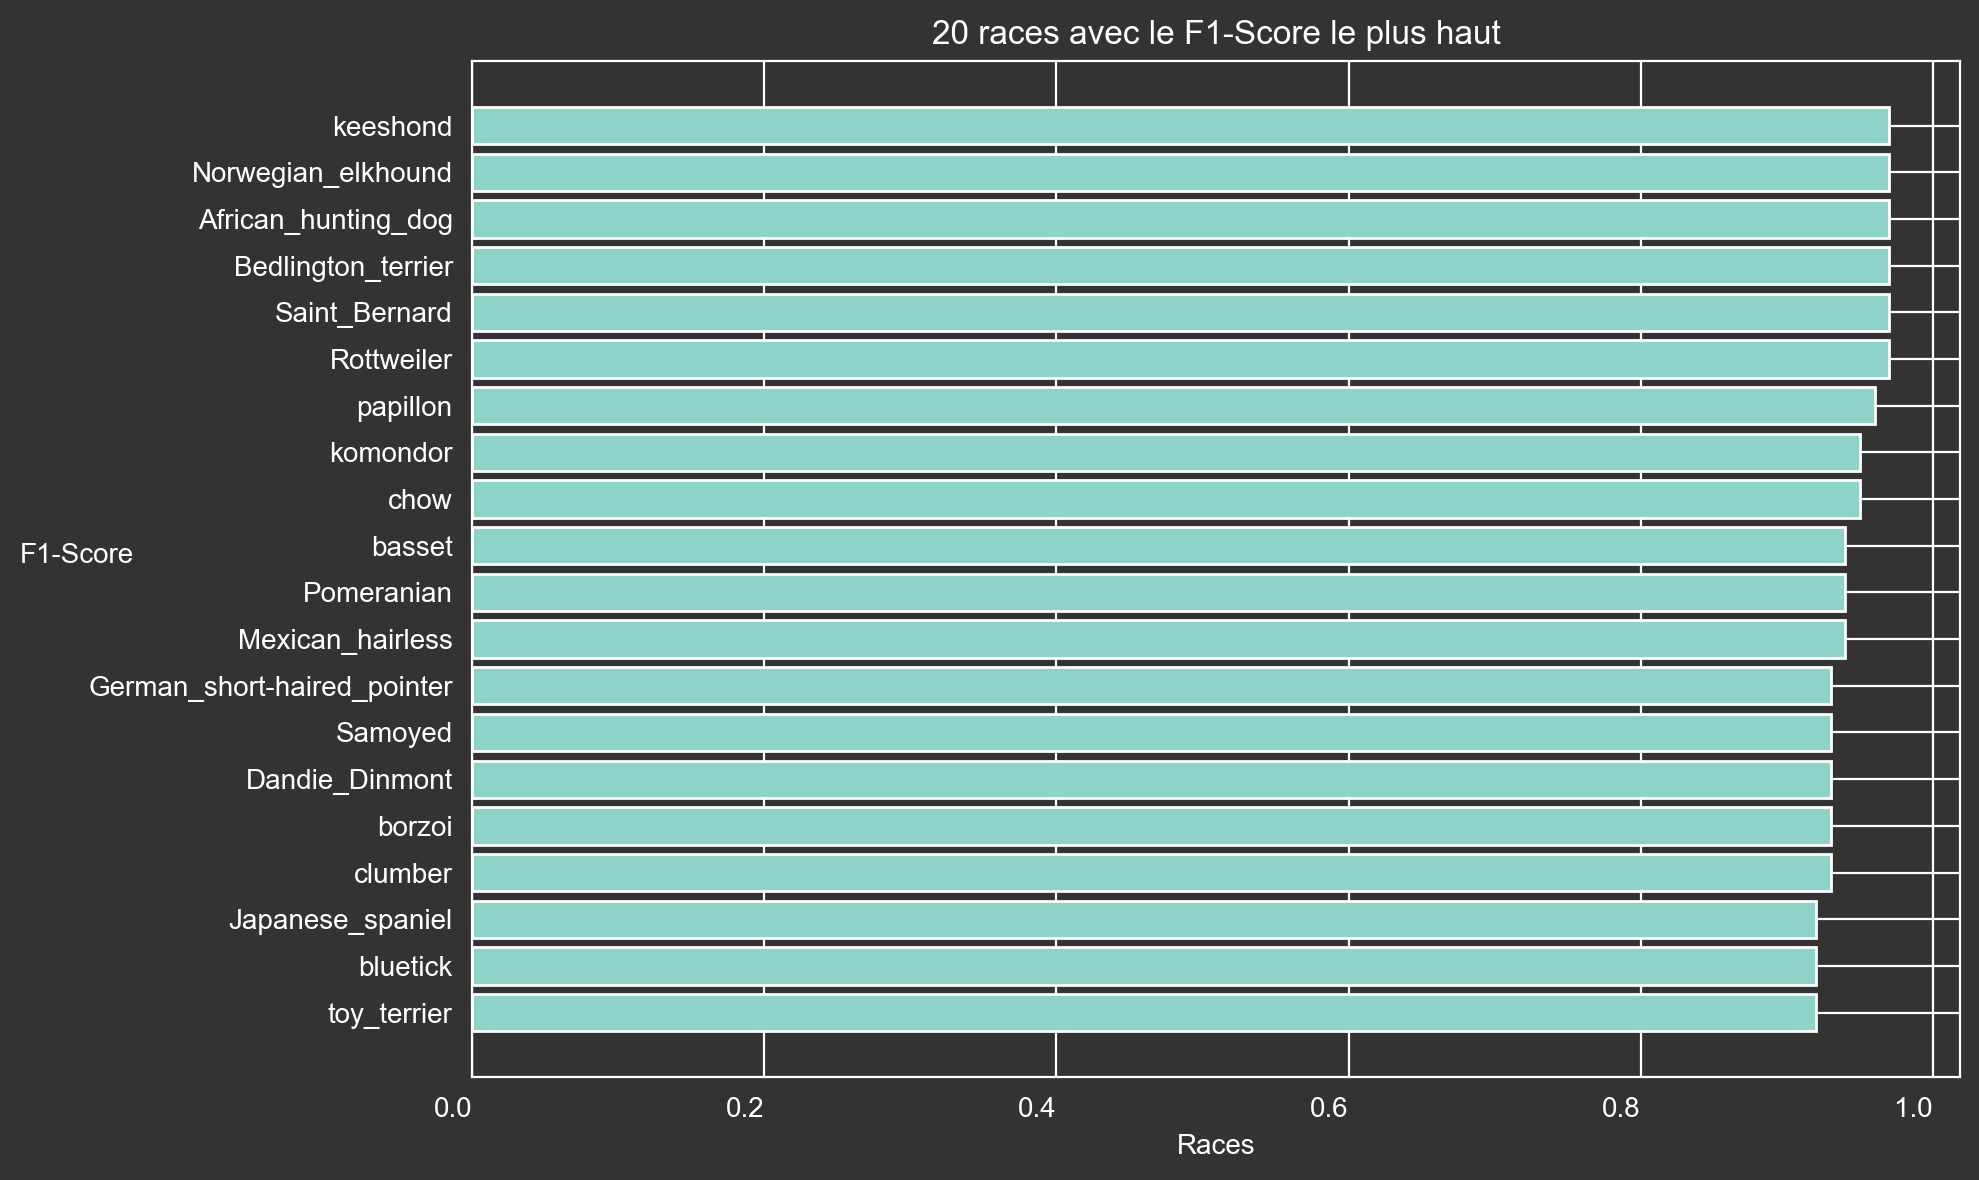

In [63]:
# Charger les données à partir du fichier CSV
df = pd.read_csv('inceptionreport.csv')

# Trier les échantillons par ordre croissant d'accuracy
df_sorted = df.sort_values(by='f1-score', ascending=True)

# Sélectionner les 10 échantillons avec l'accuracy la plus basse
lowest_accuracy_samples = df_sorted.tail(20)

# Créer un graphique en barre pour illustrer les échantillons
plt.figure(figsize=(10, 6))
plt.barh(lowest_accuracy_samples['breed'], lowest_accuracy_samples['f1-score'])
plt.xlabel('Races', color = 'white')
plt.ylabel('F1-Score', color = 'white', rotation = 360)
plt.title('20 races avec le F1-Score le plus haut')
plt.xticks(ha='right', color = 'white')
plt.yticks(color = 'white')
plt.tight_layout()

# Afficher le graphique
plt.show()

### 2.4 Sauvegarde du modèle et prédiction

In [24]:
tf.keras.models.save_model(
    model,
    filepath="model_transfer_inceptionv3_v1.2",
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)

INFO:tensorflow:Assets written to: model_transfer_inceptionv3_v1.2\assets


INFO:tensorflow:Assets written to: model_transfer_inceptionv3_v1.2\assets


In [34]:
# Fonction pour télécharger l'image depuis l'URL et la prétraiter
def preprocess_image_from_url(image_url):
    response = requests.get(image_url)
    img = Image.open(io.BytesIO(response.content))
    img = img.resize((299, 299))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

In [35]:
# Charger la liste des noms de races de chiens
breed_list = sorted(os.listdir(data_dir))

In [45]:
# URL de l'image à prédire
image_url = "https://www.purina.fr/sites/default/files/2021-02/BREED%20Hero_0034_chihuahua_smooth.jpg"
# Prétraiter l'image et effectuer la prédiction
processed_image = preprocess_image_from_url(image_url)
prediction = model.predict(processed_image)
predicted_class = np.argmax(prediction)

# Calcul du pourcentage de confiance
confidence = np.max(prediction) * 100

# Afficher le résultat de la prédiction
print("Prédiction:", breed_list[predicted_class], " Confidence :", confidence)

1/1 [==============================] - 0s 78ms/step
Prédiction: Chihuahua  Confidence : 99.94115829467773


## 3. <a name="C23">Xception</a>
<a href="#toc">Revenir en haut</a>

In [85]:
# Chemin vers le dossier principal contenant les images de chiens
data_dir = 'Images'

# Taille des images que le modèle attend en entrée
img_size = (299, 299)
num_classes = 120
epochs = 20

In [77]:
# Pré-traitement et data augmentation des images
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest'
)

In [78]:
# Charger les images depuis le répertoire et appliquer la data augmentation
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=64,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=64,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [79]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

In [80]:
# Ajouter une couche GlobalAveragePooling2D et une couche Dense pour la classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='tanh')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [81]:
# Combiner le modèle pré-entraîné avec nos nouvelles couches
model = Model(inputs=base_model.input, outputs=predictions)


In [82]:
# Geler les couches du modèle pré-entraîné pour empêcher leur mise à jour lors de l'entraînement
for layer in base_model.layers:
    layer.trainable = False

In [83]:
# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [86]:
# Afficher un résumé du modèle
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

 block4_sepconv1_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 37, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 37, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 19, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 19, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_19 (Add)                   (None, 19, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_18[0][0]']                 
                                                                                                  
 block10_sepconv1_act (Activati  (None, 19, 19, 728)  0          ['add_19[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 19, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 19, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 19, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 19, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_22 (A

In [87]:
# Entraîner le modèle
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Epoch 1/20
258/258 [==============================] - 931s 4s/step - loss: 0.7763 - accuracy: 0.7905 - val_loss: 0.6231 - val_accuracy: 0.8126
Epoch 2/20
258/258 [==============================] - 955s 4s/step - loss: 0.4962 - accuracy: 0.8453 - val_loss: 0.5480 - val_accuracy: 0.8450
Epoch 3/20
258/258 [==============================] - 974s 4s/step - loss: 0.4450 - accuracy: 0.8577 - val_loss: 0.5948 - val_accuracy: 0.8313
Epoch 4/20
258/258 [==============================] - 973s 4s/step - loss: 0.4082 - accuracy: 0.8692 - val_loss: 0.6232 - val_accuracy: 0.8306
Epoch 5/20
258/258 [==============================] - 976s 4s/step - loss: 0.3853 - accuracy: 0.8718 - val_loss: 0.5840 - val_accuracy: 0.8369
Epoch 6/20
258/258 [==============================] - 973s 4s/step - loss: 0.3659 - accuracy: 0.8809 - val_loss: 0.5943 - val_accuracy: 0.8360
Epoch 7/20
258/258 [==============================] - 976s 4s/step - loss: 0.3351 - accuracy: 0.8910 - val_loss: 0.6165 - val_accuracy: 0.8308

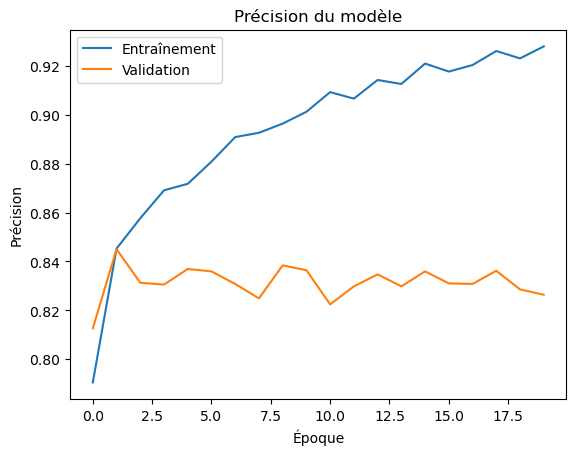

In [88]:
# Tracer les courbes d'apprentissage
# Précision d'entraînement et de validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du modèle')
plt.ylabel('Précision')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper left')
plt.show()

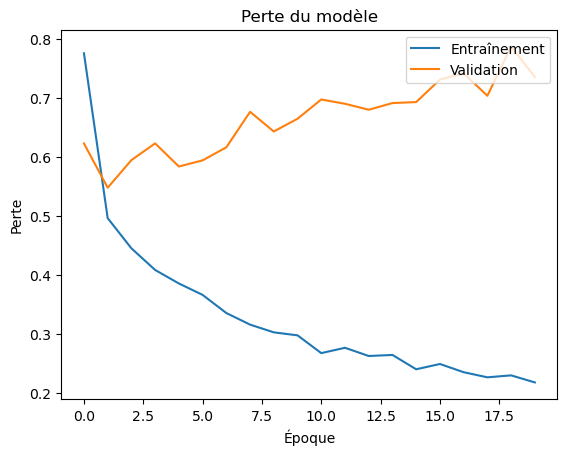

In [89]:
# Perte d'entraînement et de validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perte du modèle')
plt.ylabel('Perte')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper right')
plt.show()

In [90]:
# Classification report pour évaluer les performances du modèle sur le jeu de validation
# Prédictions sur le jeu de validation
Y_val_true = val_generator.classes
Y_val_pred = model.predict(val_generator)

64/64 [==============================] - 203s 3s/step


In [91]:
# Récupérer les indices des classes prédites avec les probabilités les plus élevées
Y_val_pred_classes = np.argmax(Y_val_pred, axis=1)

In [92]:
# Afficher le classification report
class_labels = list(val_generator.class_indices.keys())
print(classification_report(Y_val_true, Y_val_pred_classes, target_names=class_labels))

                                precision    recall  f1-score   support

                  Afghan_hound       0.92      0.96      0.94        47
           African_hunting_dog       1.00      1.00      1.00        33
                      Airedale       0.81      0.88      0.84        40
American_Staffordshire_terrier       0.75      0.66      0.70        32
                   Appenzeller       0.78      0.70      0.74        30
            Australian_terrier       0.78      0.82      0.80        39
            Bedlington_terrier       0.95      1.00      0.97        36
          Bernese_mountain_dog       0.93      0.95      0.94        43
              Blenheim_spaniel       0.97      0.92      0.94        37
                 Border_collie       0.93      0.43      0.59        30
                Border_terrier       0.89      0.94      0.91        34
                   Boston_bull       0.94      0.94      0.94        36
          Bouvier_des_Flandres       0.83      0.97      0.89  

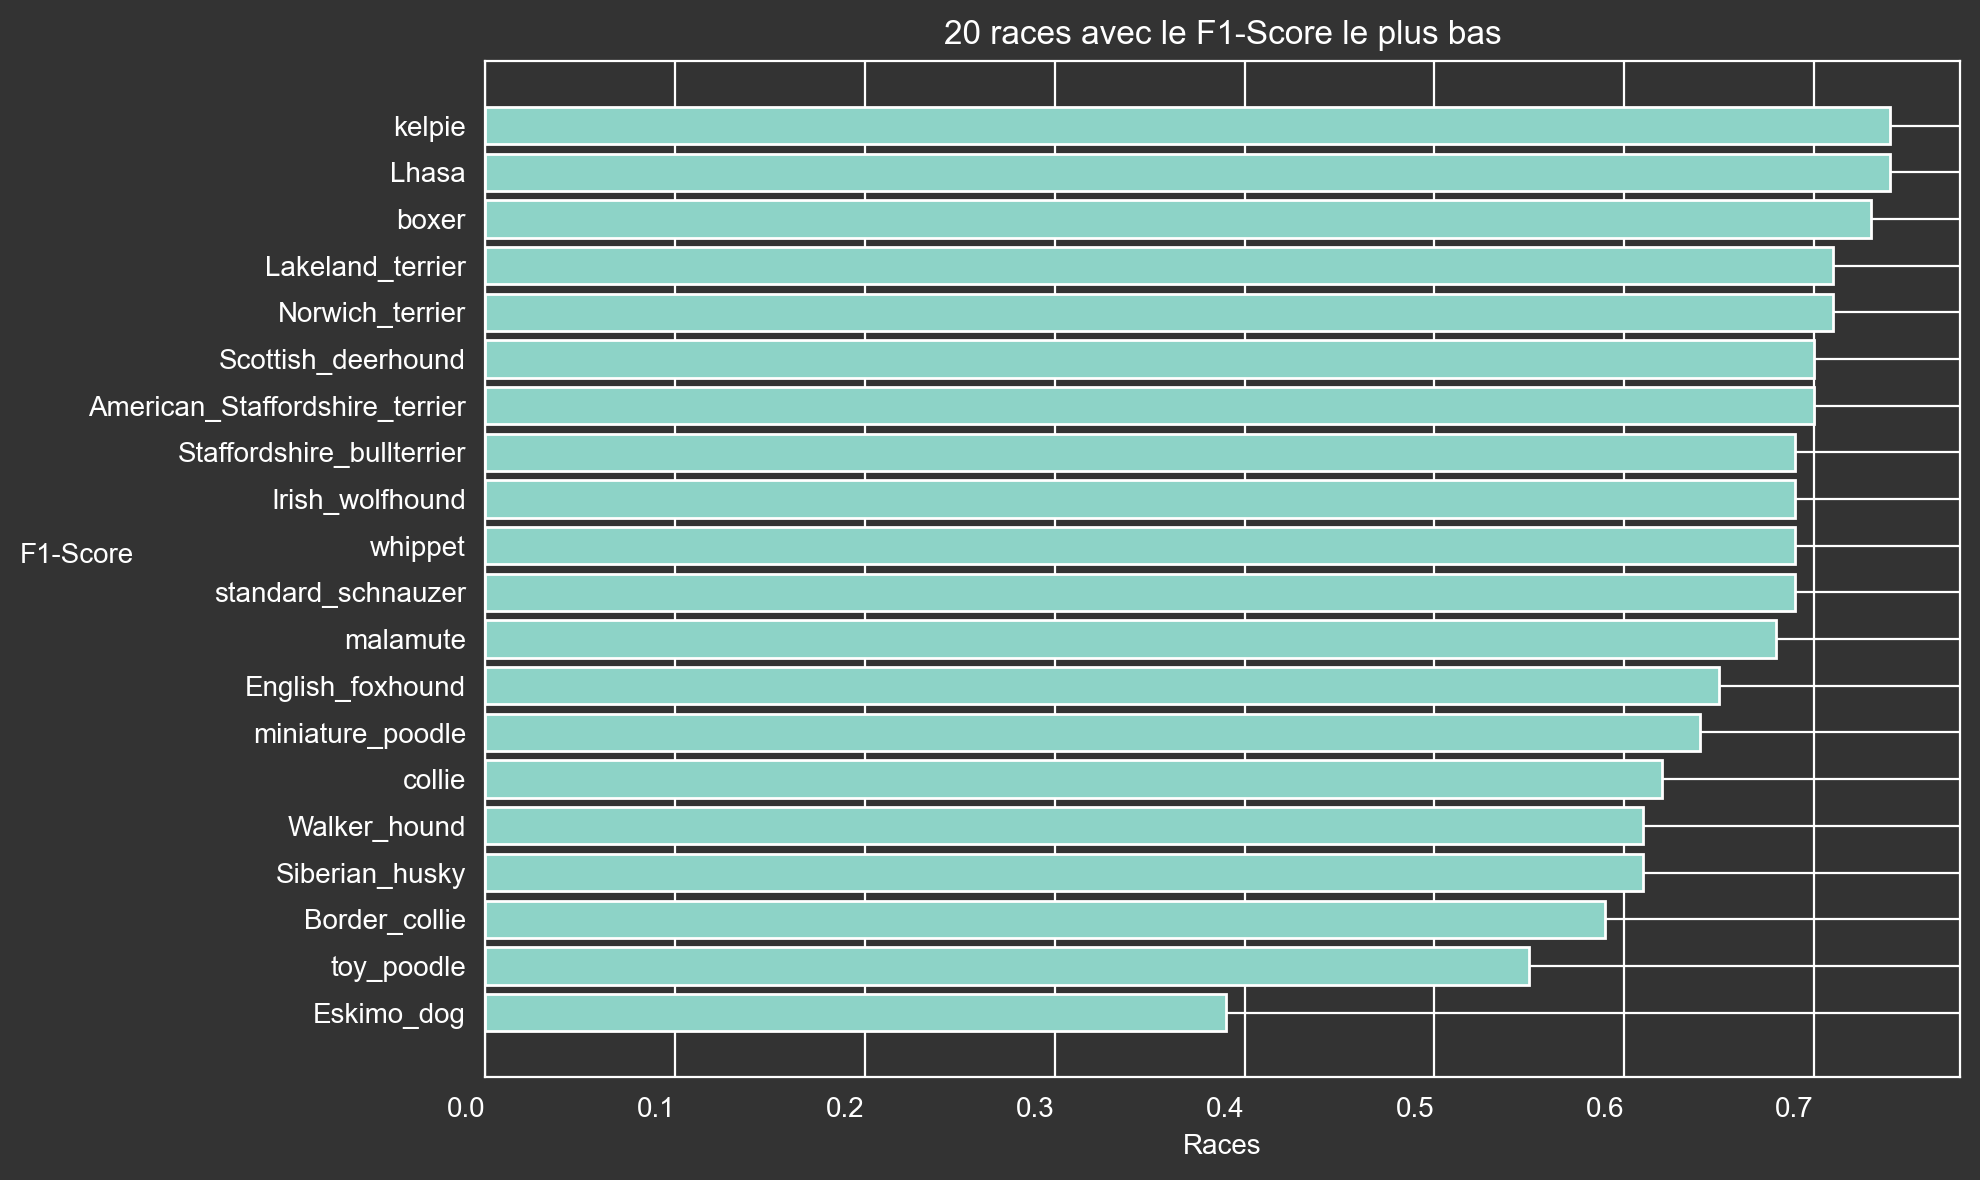

In [58]:
# Charger les données à partir du fichier CSV
df = pd.read_csv('xceptionreport.csv')

# Trier les échantillons par ordre croissant d'accuracy
df_sorted = df.sort_values(by='f1-score', ascending=True)

# Sélectionner les 10 échantillons avec l'accuracy la plus basse
lowest_accuracy_samples = df_sorted.head(20)

# Créer un graphique en barre pour illustrer les échantillons
plt.figure(figsize=(10, 6))
plt.barh(lowest_accuracy_samples['breed'], lowest_accuracy_samples['f1-score'])
plt.xlabel('Races', color = 'white')
plt.ylabel('F1-Score', color = 'white', rotation = 360)
plt.title('20 races avec le F1-Score le plus bas')
plt.xticks(ha='right', color = 'white')
plt.yticks(color = 'white')
plt.tight_layout()

# Afficher le graphique
plt.show()

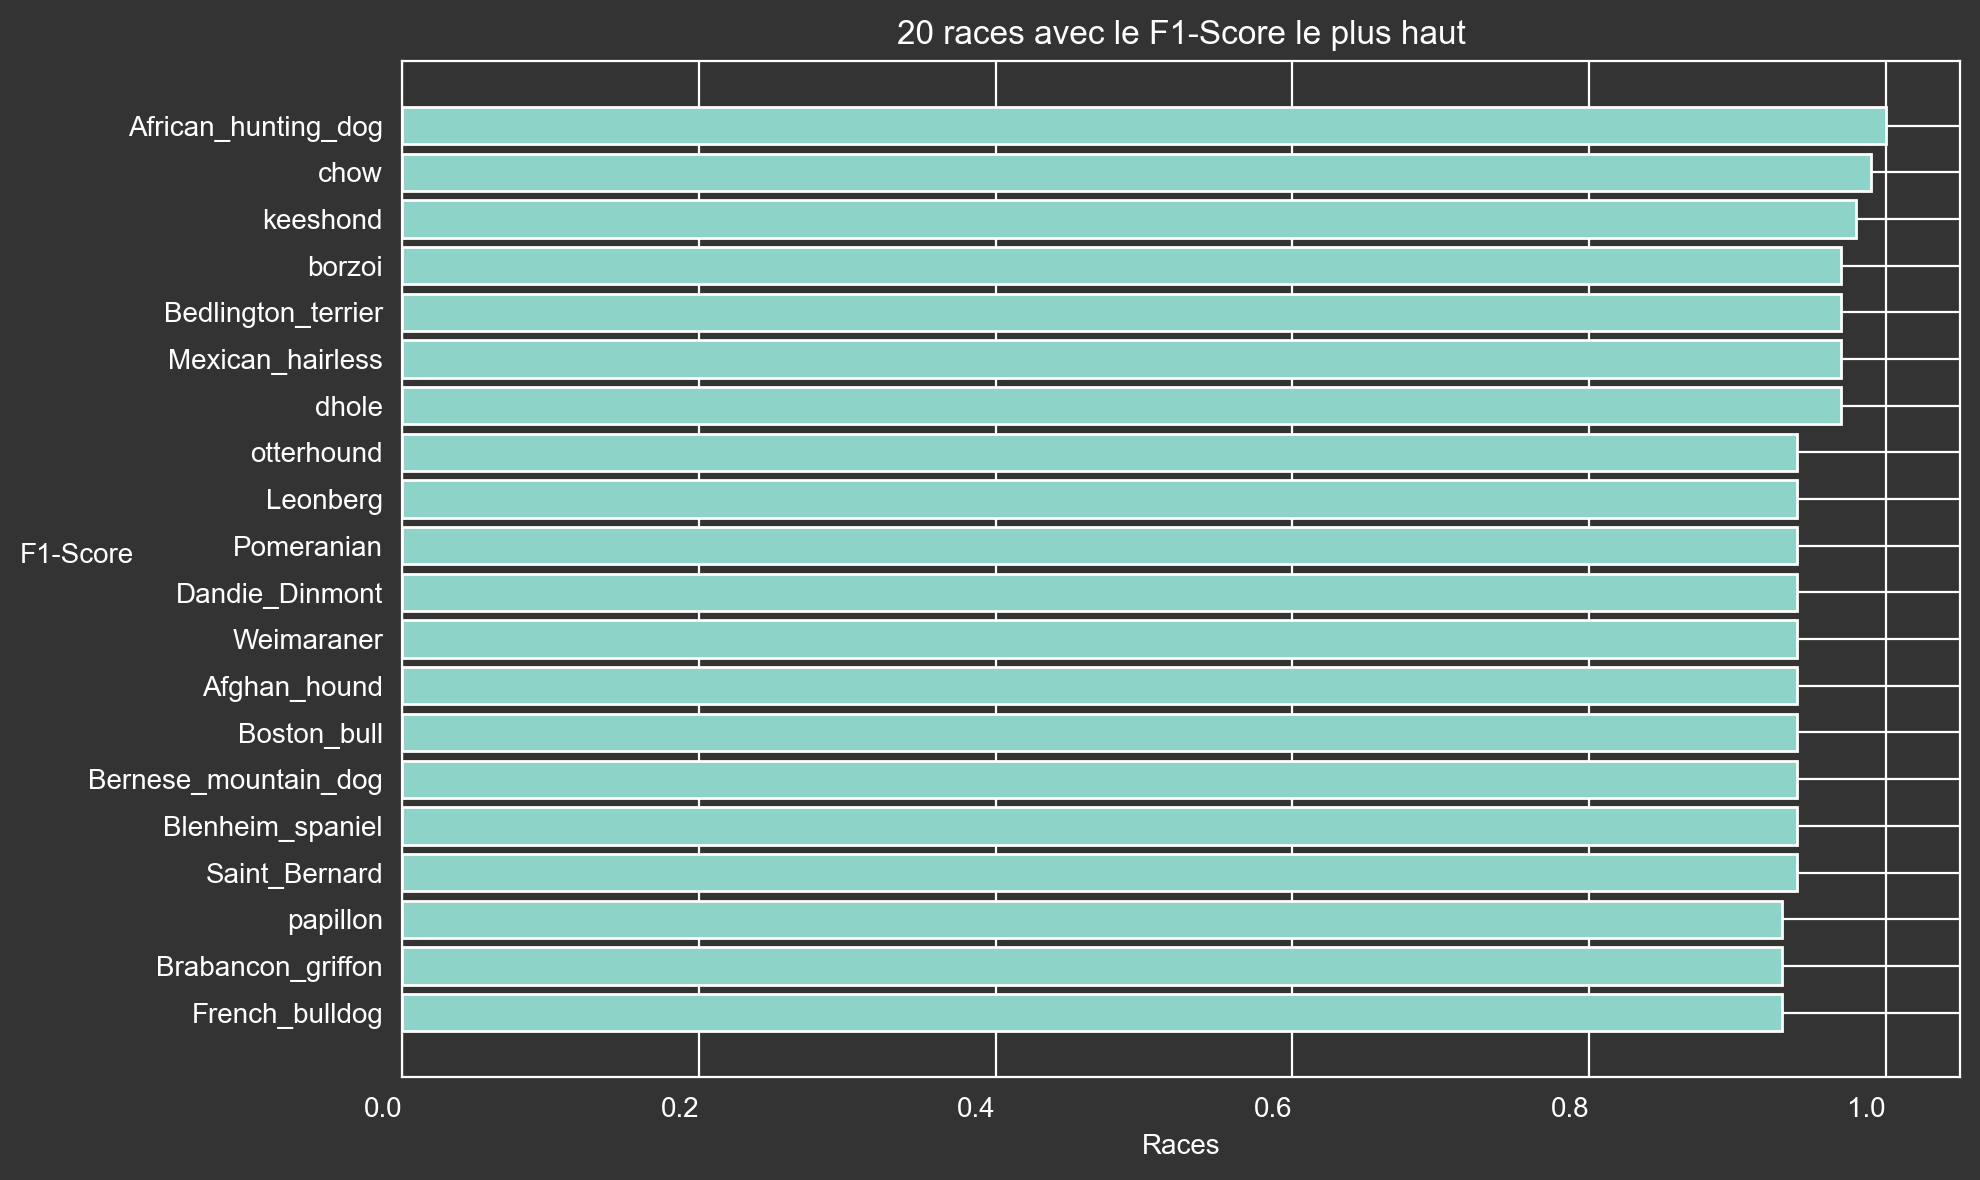

In [60]:
# Charger les données à partir du fichier CSV
df = pd.read_csv('xceptionreport.csv')

# Trier les échantillons par ordre croissant d'accuracy
df_sorted = df.sort_values(by='f1-score', ascending=True)

# Sélectionner les 10 échantillons avec l'accuracy la plus basse
lowest_accuracy_samples = df_sorted.tail(20)

# Créer un graphique en barre pour illustrer les échantillons
plt.figure(figsize=(10, 6))
plt.barh(lowest_accuracy_samples['breed'], lowest_accuracy_samples['f1-score'])
plt.xlabel('Races', color = 'white')
plt.ylabel('F1-Score', color = 'white', rotation = 360)
plt.title('20 races avec le F1-Score le plus haut')
plt.xticks(ha='right', color = 'white')
plt.yticks(color = 'white')
plt.tight_layout()

# Afficher le graphique
plt.show()

In [93]:
tf.keras.models.save_model(
    model,
    filepath="model_transfer_xception_v1.1",
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)

INFO:tensorflow:Assets written to: model_transfer_xception_v1.1\assets


INFO:tensorflow:Assets written to: model_transfer_xception_v1.1\assets


## 4. <a name="C24">Sélection Finale</a>
<a href="#toc">Revenir en haut</a>

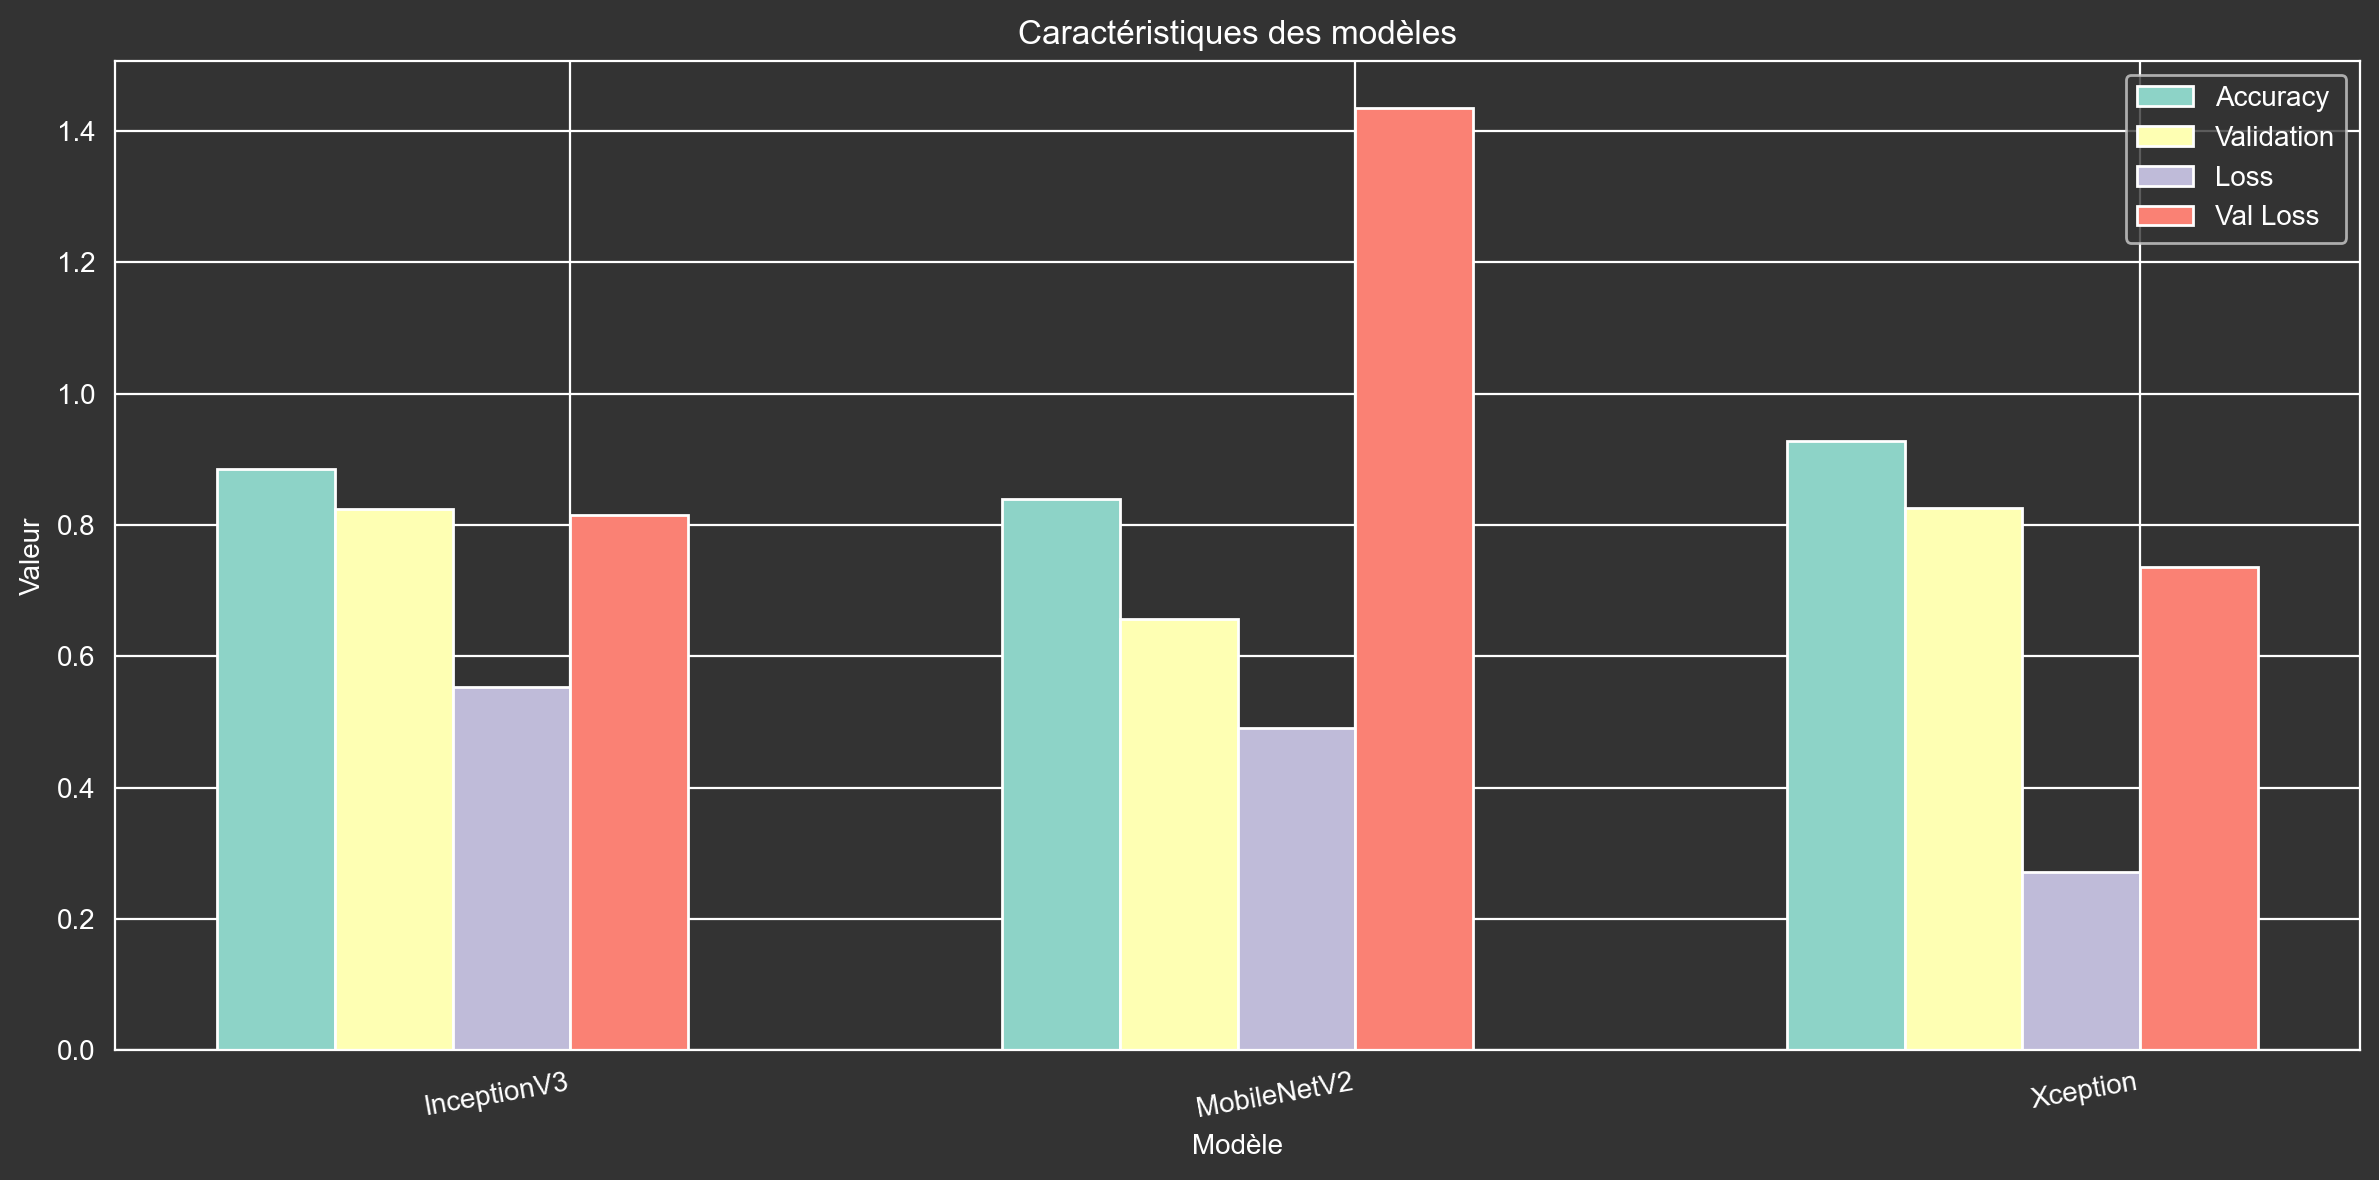

In [67]:
# Données
models = [
    "InceptionV3",
    "MobileNetV2",
    "Xception"
]

accuracy = [0.8844, 0.84, 0.9281]
validation = [0.8239, 0.6574, 0.8264]
loss = [0.5528, 0.49, 0.2713]
val_loss = [0.8156, 1.435, 0.7359]

# Création du graphique
plt.figure(figsize=(12, 6))
index = range(len(models))
bar_width = 0.15

plt.bar(index, accuracy, bar_width, label='Accuracy')
plt.bar([i + bar_width for i in index], validation, bar_width, label='Validation')
plt.bar([i + bar_width * 2 for i in index], loss, bar_width, label='Loss')
plt.bar([i + bar_width * 3 for i in index], val_loss, bar_width, label='Val Loss')

plt.xlabel('Modèle', color = 'white')
plt.ylabel('Valeur', color = 'white')
plt.title('Caractéristiques des modèles')
plt.xticks([i + bar_width * 2.5 for i in index], models, rotation=10, ha="right", color = 'white')
plt.yticks(color = 'white')
plt.legend()

plt.tight_layout()
plt.show()

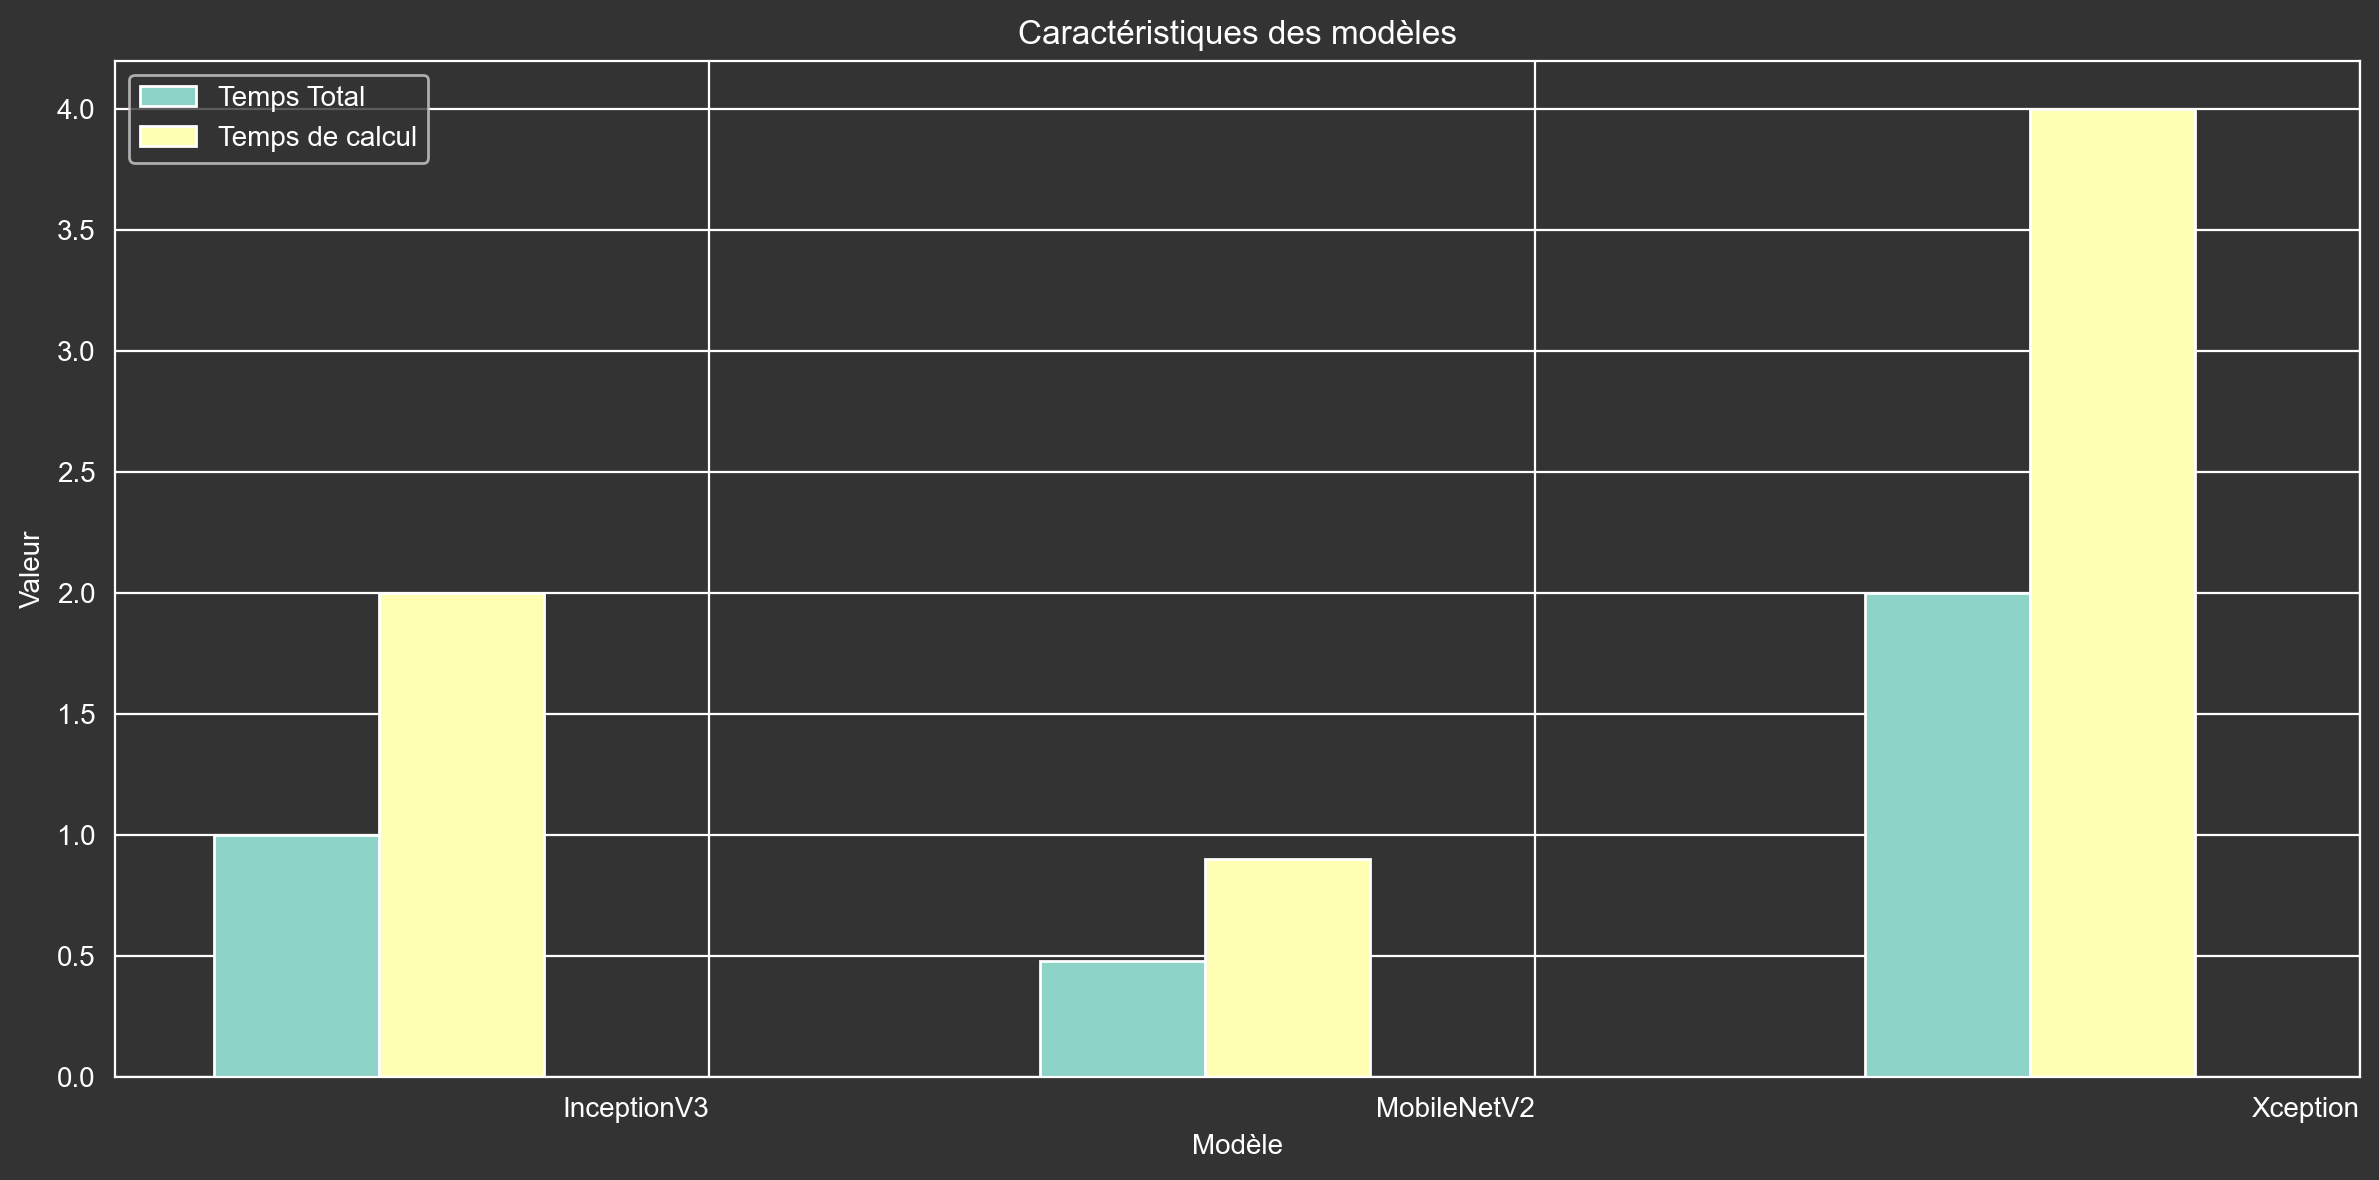

In [15]:
# Données
models = [
    "InceptionV3",
    "MobileNetV2",
    "Xception"
]

total_time = [1, 0.48, 2]
computing_time = [2, 0.9, 4]

# Création du graphique
plt.figure(figsize=(12, 6))
index = range(len(models))
bar_width = 0.2

plt.bar(index, total_time, bar_width, label='Temps Total')
plt.bar([i + bar_width for i in index], computing_time, bar_width, label='Temps de calcul')

plt.xlabel('Modèle', color = 'white')
plt.ylabel('Valeur', color = 'white')
plt.title('Caractéristiques des modèles')
plt.xticks([i + bar_width * 2.5 for i in index], models, ha="right", color = 'white')
plt.yticks(color = 'white')
plt.legend()

plt.tight_layout()
plt.show()

#### Xception possède très légérement une meilleure validation accuracy, ainsi que validation loss mais son temps de calcul est trop long, à l'inverse MobileNetV2 est extrêmement rapide mais pas assez performant.
#### Le choix du modèle final sera donc InceptionV3 pour sa polyvalence globale par rapport aux autres modèles.